In [70]:
import numpy as np
import pandas as pd
import os
from os.path import join, pardir
DATA_DIR = join(pardir, pardir, 'data', 'write_new_algorithm')

dfs = []
for mem in [512, 1024, 2048]:
    
    for size in [4, 1024, 65536, 131072, 256000]:
        df = pd.read_csv(join(DATA_DIR, f'persistent_{size}_{mem}_processed.csv'), index_col=0)
        df['size'] = size / 1024
        
        #print(df)
        # data is broken :-(
        #df = df.loc[df['memory'] == mem]
        #df = df.groupby(['memory', 'function']).head(150).reset_index(drop=True)
        #if df.shape[0] > 200:
        #    print(size, mem)
        dfs.append(df)
        
        
dynamo_df = pd.concat(dfs)
dynamo_df['system'] = 'persistent'
dynamo_df['gbs'] = dynamo_df['billed_time'] * dynamo_df['memory'] / 1024.0 / 1000
#print(dynamo_df)
#print(dynamo_df.groupby(['function', 'memory', 'size']).median()['gbs'])
#for memory in [512, 1024, 2048]

data = {}
for f in ['writer', 'distributor']:
    data[f] = {}
    for m in [512, 1024, 2048]:
        data[f][m] = []

for name, group in dynamo_df.groupby(['function', 'memory', 'size']):
    data[name[0]][name[1]].append(group['gbs'].median())
print(data)

{'writer': {512: [0.0175, 0.016, 0.0365, 0.0615, 0.112], 1024: [0.031, 0.036, 0.0475, 0.08, 0.126], 2048: [0.064, 0.064, 0.096, 0.134, 0.206]}, 'distributor': {512: [0.0305, 0.0305, 0.046, 0.0375, 0.0705], 1024: [0.066, 0.068, 0.087, 0.076, 0.1255], 2048: [0.126, 0.128, 0.174, 0.15, 0.266]}}


In [71]:
import numpy as np
from sklearn.linear_model import LinearRegression

x = np.array([5, 15, 25, 35, 45, 55]).reshape((-1, 1))
y = np.array([5, 20, 14, 32, 22, 38])
#model = LinearRegression().fit(x, y)
#r_sq = model.score(x, y)
#print('coefficient of determination:', r_sq)

coefficients = {}

x = np.array([0.003906, 1.000000, 64, 128, 250]).reshape((-1, 1))
for f in ['writer', 'distributor']:
    coefficients[f] = {}
    for m in [512, 1024, 2048]:
        y = data[f][m]
        model = LinearRegression().fit(x, y)
        print(f, m, model.score(x, y))
        print(f, m, model.intercept_)
        print(f, m, model.coef_)
        coefficients[f][m] = (model.coef_[0], model.intercept_)

writer 512 0.9963644802244943
writer 512 0.014966494004788104
writer 512 [0.00038074]
writer 1024 0.9871717634314536
writer 1024 0.03083290883434315
writer 1024 [0.00037547]
writer 2048 0.9989504094603819
writer 2048 0.06237247873913875
writer 2048 [0.00056915]
distributor 512 0.8323095564630623
distributor 512 0.03013358333813803
distributor 512 [0.00014522]
distributor 1024 0.8340794980527049
distributor 1024 0.06564661349131273
distributor 1024 [0.00021279]
distributor 2048 0.8446768498912897
distributor 2048 0.12385090667403802
distributor 2048 [0.00050732]


## Cost model

In [72]:
import math
# PUT, COPY, POST, LIST requests (per 1,000 requests)
def write_s3(s):
    return  5*10**-6
def read_s3(s):
    return  0.4*10**-6
def write_dynamodb(s):
    return math.ceil(s) * 1.25 * 10**-6
def read_dynamodb(s):
    return math.ceil(s/4.0) * 0.25 * 10**-6
# FIFO Queues (per Million requests) 0.5
def sqs(s):
    return math.ceil(s/64.0) * 0.5 * 10**-6

lambda_const = 1.66667 * 10**-5

def writer(m, s):
    return lambda_const*(coefficients['writer'][m][0] * s + coefficients['writer'][m][1]) + 0.2 * 10**-6
def distributor(m, s):
    return lambda_const*(coefficients['distributor'][m][0] * s + coefficients['distributor'][m][1]) + 0.2 * 10**-6

def total_cost(m, s):
    return 2 * sqs(s) + 3 * write_dynamodb(1) + read_dynamodb(1) + write_s3(s) + writer(m, s) + distributor(m, s)


In [73]:
print(round(total_cost(512, 1)*100000,2))

1.12


In [203]:

ratio = 1.0
cost = ratio * 0.4 * 10**-6 + (1-ratio)*total_cost(512, 1)

print(t3_small, cost, t3_small/cost)
ratio = 0.9
cost = ratio * 0.4 * 10**-6 + (1-ratio)*total_cost(512, 1)

print(t3_small, cost, t3_small/cost)
ratio = 0.75
cost = ratio * 0.4 * 10**-6 + (1-ratio)*total_cost(512, 1)
print(t3_medium, cost, t3_medium/cost)

1.4975999999999998 4e-07 3743999.9999999995
1.4975999999999998 1.4760435374209536e-06 1014604.2186646549
2.9951999999999996 3.0901088435523843e-06 969286.2457740234


## Plot

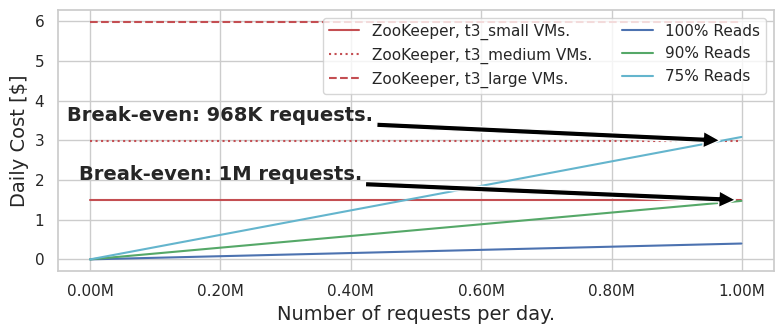

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.ticker as ticker

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,3.5)})
sns.set_style("whitegrid")

def p50_estimator(x):                                            
    return np.percentile(x, 50)           

# EC2
# t3.small
zk_vms = 3
t3_small = zk_vms * 0.0208 * 24
t3_medium = zk_vms * 0.0416 * 24
t3_large = zk_vms * 0.0832 * 24

reqs_begin = 1
reqs_end = 10**6
reqs_step = 1000
x = list(range(reqs_begin, reqs_end, reqs_step))

for val, color, style, label, in [(t3_small, 'r', 'solid', 'ZooKeeper, t3_small VMs.'), (t3_medium, 'r', 'dotted', 'ZooKeeper, t3_medium VMs.'), (t3_large,'r', '--', 'ZooKeeper, t3_large VMs.')]:
    y = [val] * len(x)
    sns.lineplot(x=x,y=y, color = color, linestyle=style, label=label)
    
# 100% read scenario
cost = 0.4 * 10**-6
y_cost = map(lambda x : x * cost, x)
sns.lineplot(x=x,y=y_cost, color='b', label='100% Reads')

# 90% read scenario
cost = 0.4 * 10**-6
ratio = 0.9
y_cost = map(lambda x : ratio * x * cost + (1-ratio)*total_cost(512,1)*x, x)
#print(x[-1])
#print(list(y_cost)[-1])
sns.lineplot(x=x,y=y_cost, color='g', label='90% Reads')

# 75% read scenario
cost = 0.4 * 10**-6
ratio = 0.75
y_cost = map(lambda x : ratio * x * cost + (1-ratio)*total_cost(512,1)*x, x)
g = sns.lineplot(x=x,y=y_cost, color='c', label='75% Reads')

# 50% read scenario
#cost = 0.4 * 10**-6
#ratio = 0.5
#y_cost = map(lambda x : ratio * x * cost + (1-ratio)*total_cost(512,1)*x, x)
#g = sns.lineplot(x=x,y=y_cost, color='m', label='50% Reads')

#plt.grid(axis='y')
#plt.title(benchmark, fontsize=20)
#plt.xlabel('Requests submitted [op/s]',fontsize=14)
#plt.ylabel('Results received [log, op/s]', fontsize=14)

plt.xlabel('Number of requests per day.',fontsize=14)
plt.ylabel('Daily Cost [$]',fontsize=14)
#plt.xticks(x)
# plt.ylim(ymin=0)
#plt.legend(ncol=3)

#plt.xlim(10**3, 10**7)
#plt.ylim(10**-2,10**2)
#plt.yscale('log')

g.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000/1000) + 'M'))

#print(plt.xticks())
#xlabels = ['{:,.2f}'.format(x/1000/1000) + 'M' for x in plt.xticks()]
#plt.xticklabels(xlabels)


g.annotate(
    'Break-even: 1M requests.',
    xy=(0.99*10**6, 1.5), xytext=(0.2*10**6, 2),
    fontsize=14, fontweight='bold', arrowprops=dict(facecolor='black', shrink=0), ha='center'
)

g.annotate(
    'Break-even: 968K requests.',
    xy=(0.966*10**6, 3), xytext=(0.2*10**6, 3.5),
    fontsize=14, fontweight='bold', arrowprops=dict(facecolor='black', shrink=0), ha='center'
)


plt.legend(ncol=2)
plt.rcParams['figure.dpi'] = 500
plt.tight_layout()

#plt.savefig("cost_model.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)
#plt.legend()
#plt.savefig(os.path.join(usm_data_dir, machine, "plots", f'time_{benchmark}.pdf'))

#plt.show()

[[37.44, 14.975999999999999, 7.4879999999999995, 4.992, 3.7439999999999998], [62.4, 24.96, 12.48, 8.32, 6.24], [87.35999999999999, 34.944, 17.472, 11.648, 8.736], [112.32, 44.928000000000004, 22.464000000000002, 14.976, 11.232000000000001], [74.88, 29.951999999999998, 14.975999999999999, 9.984, 7.4879999999999995], [124.8, 49.92, 24.96, 16.64, 12.48], [174.71999999999997, 69.888, 34.944, 23.296, 17.472], [224.64, 89.85600000000001, 44.928000000000004, 29.952, 22.464000000000002], [149.76, 59.903999999999996, 29.951999999999998, 19.968, 14.975999999999999], [249.6, 99.84, 49.92, 33.28, 24.96], [349.43999999999994, 139.776, 69.888, 46.592, 34.944], [449.28, 179.71200000000002, 89.85600000000001, 59.904, 44.928000000000004]]


Text(0.5, 1.0, 'FaaSKeeper savings over ZooKeeper, 100% reads.')

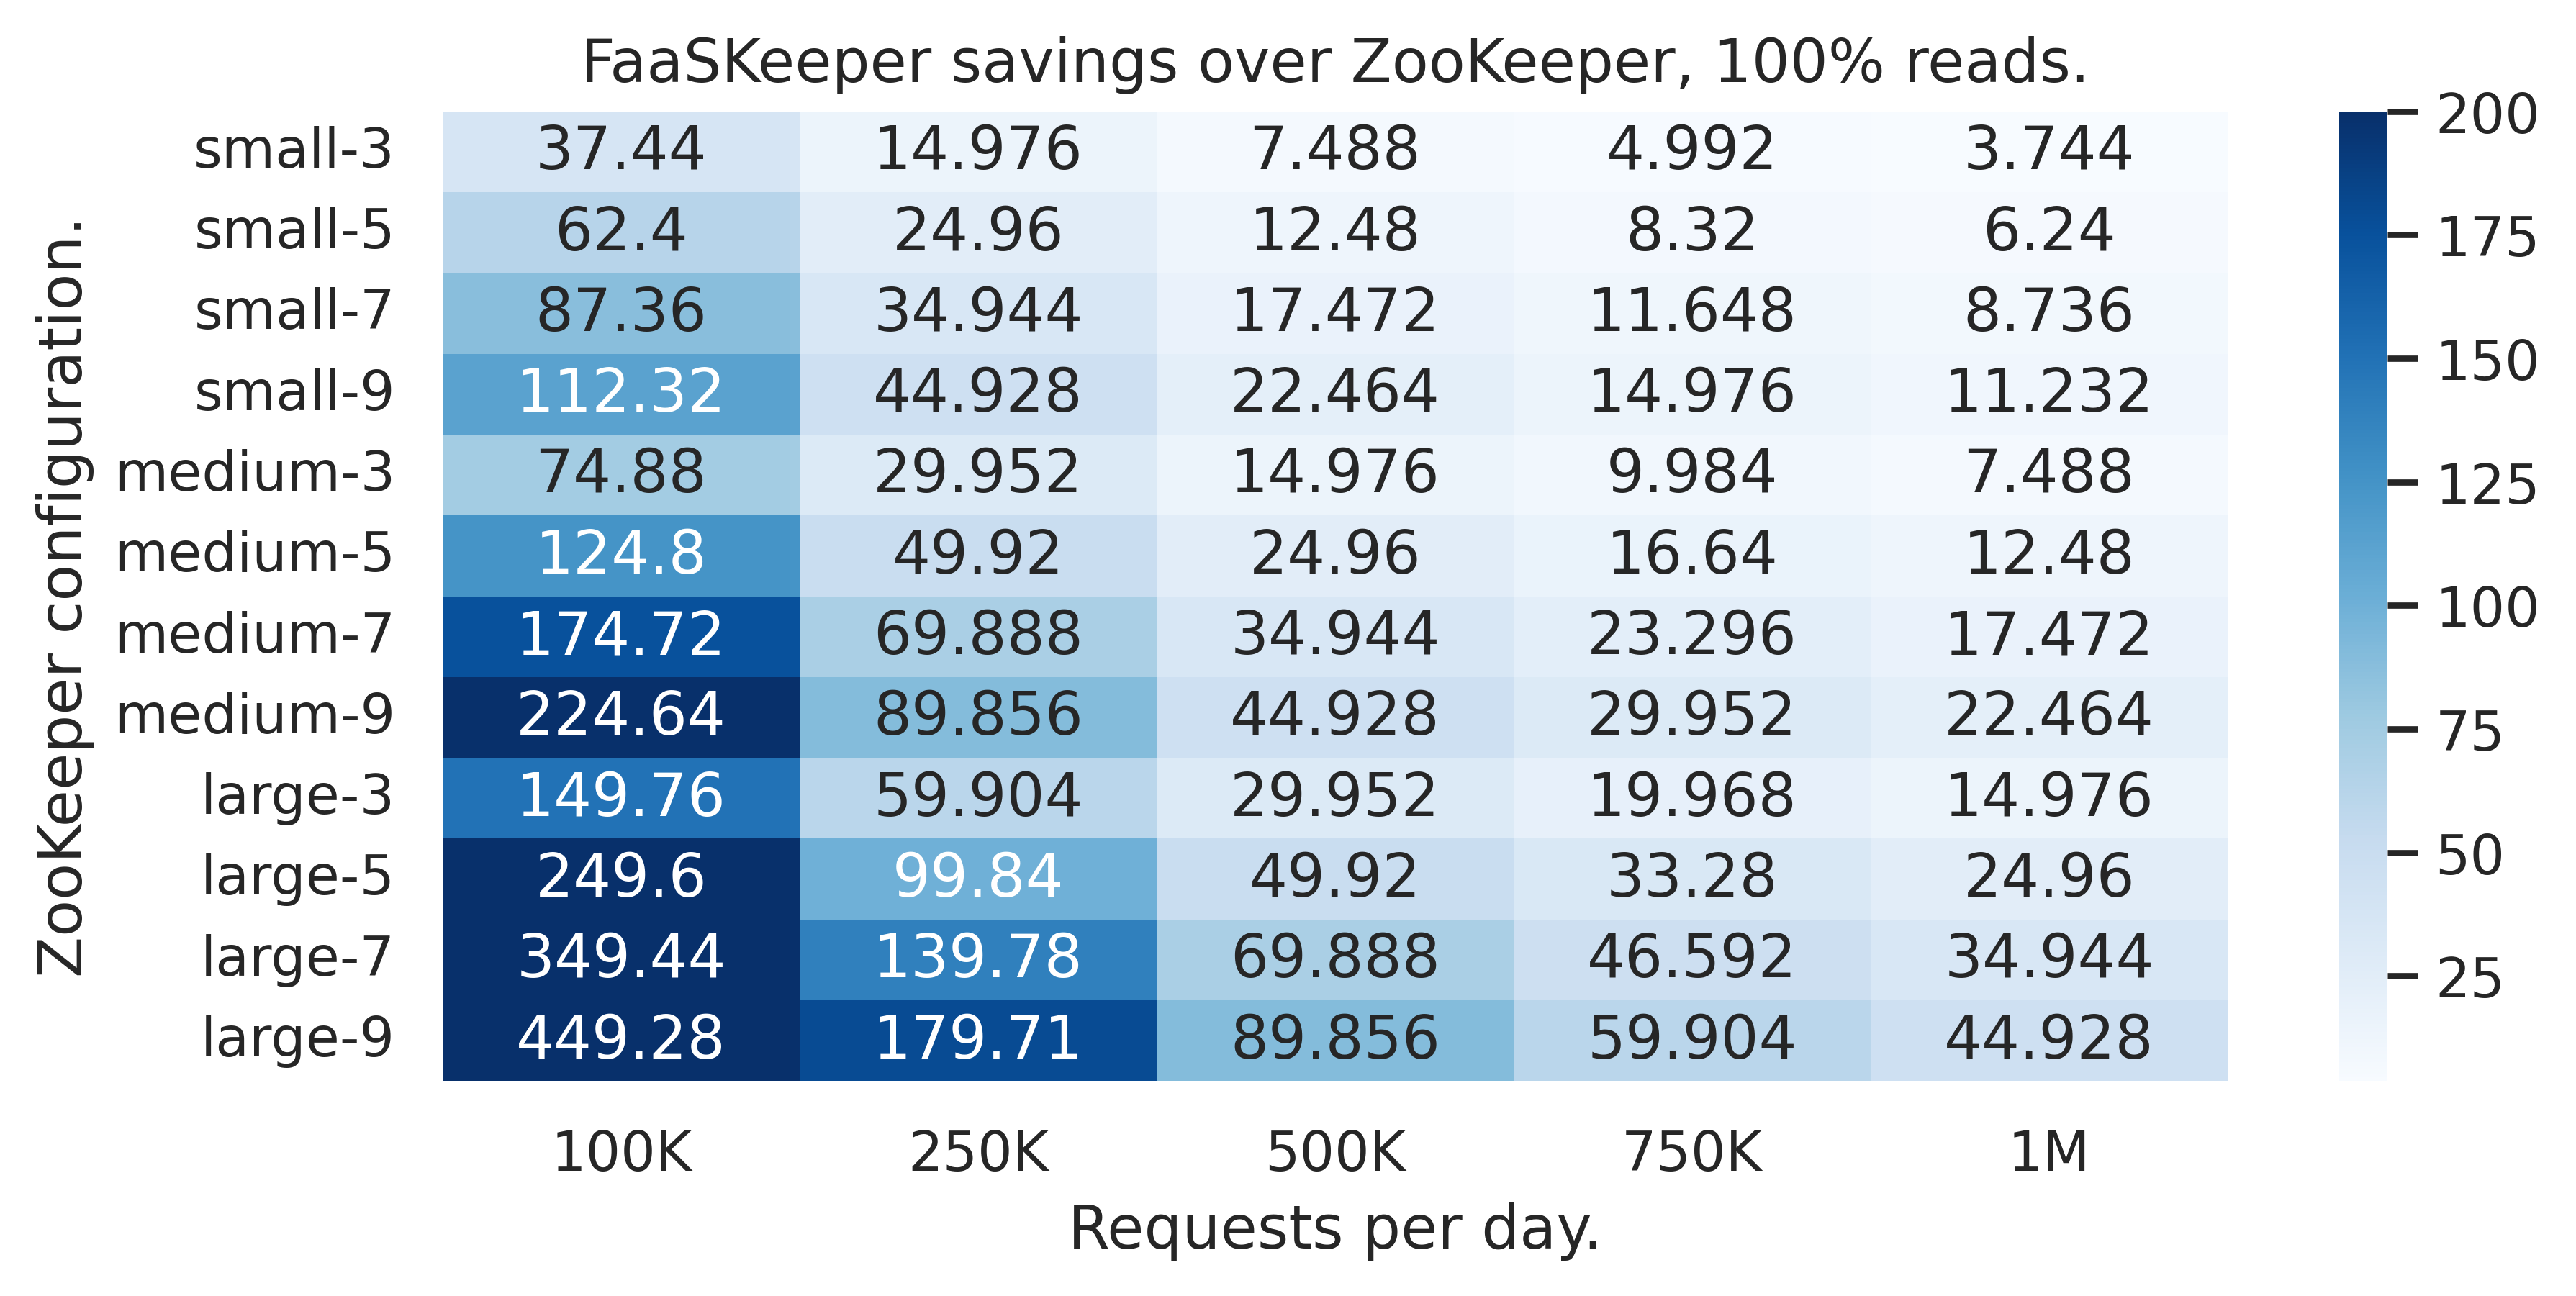

In [43]:

#zk_vms = 3
t3_cost = {
    'small': 0.0208 * 24,
    'medium': 0.0416 * 24,
    'large': 0.0832 * 24
}        
requests = [100, 250, 500, 750, 1000]
        
# 512 MB, 1 kB


results = []
labels = []

for size in ['small', 'medium', 'large']:

    for vms in [3, 5, 7, 9]:
    
        
        cost = 0.4 * 10**-6
        ratio = 1.0
        
        y_cost = list(map(lambda x : ratio * x * cost + (1-ratio)*total_cost(512,1)*x, [1000*x for x in requests]))
        zk_cost = [t3_cost[size] * vms] * len(y_cost)
        
        ratio = []
        for i in range(len(zk_cost)):
            #print(zk_cost[i], y_cost[i])
            ratio.append(zk_cost[i] / y_cost[i])
        results.append(ratio)
        labels.append(f'{size}_{vms}')
        
        
requests_labels = ['100K', '250K', '500K', '750K', '1M']

cols = pd.MultiIndex.from_tuples([("small", "3"), 
                                  ("small", "5"),
                                  ("small", "7"), 
                                  ("small", "9"),
                                  ("medium", "3"), 
                                  ("medium", "5"),
                                  ("medium", "7"), 
                                  ("medium", "9"),
                                  ("large", "3"), 
                                  ("large", "5"),
                                  ("large", "7"), 
                                  ("large", "9")])
print(results)
matrix_df = pd.DataFrame(results,columns=requests_labels,index=cols)


fig = sns.heatmap(matrix_df,
            cmap='Blues',
            annot=True,
            fmt='.5g',
            vmax=200)
fig.set_xlabel('Requests per day.')
fig.set_ylabel('ZooKeeper configuration.')
fig.set_title('FaaSKeeper savings over ZooKeeper, 100% reads.')


Text(0.5, 1.0, 'FaaSKeeper savings over ZooKeeper, 100% reads.')

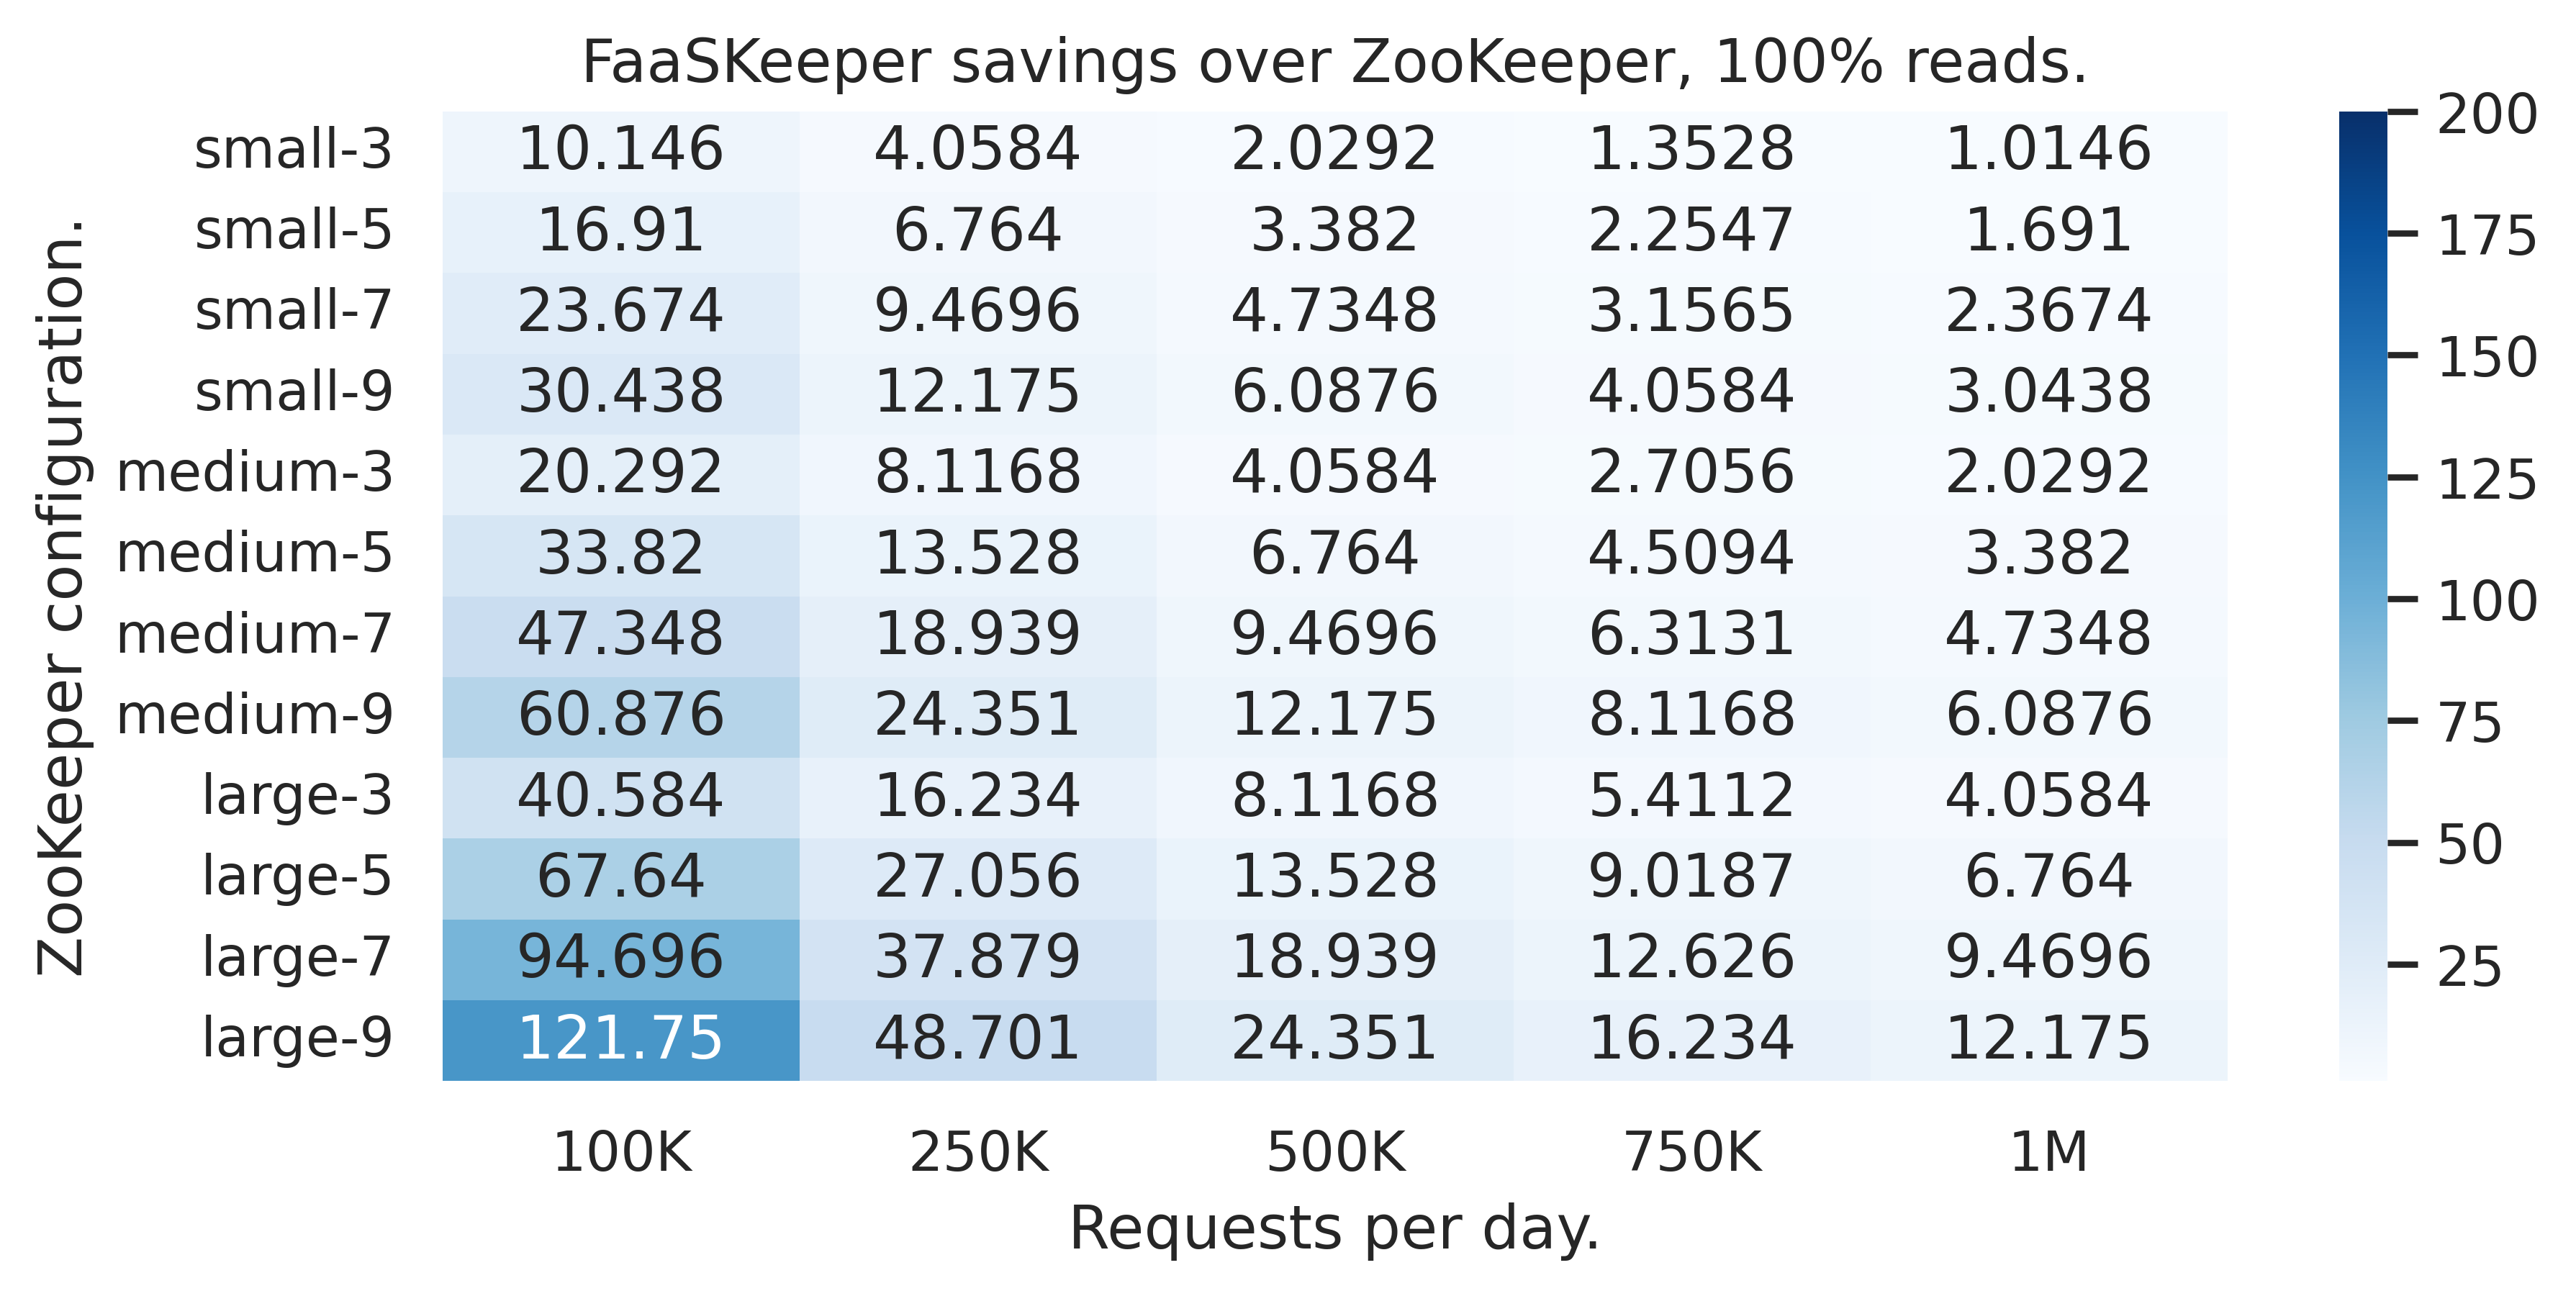

0.7487999999999999 449.28
0.0 10.0


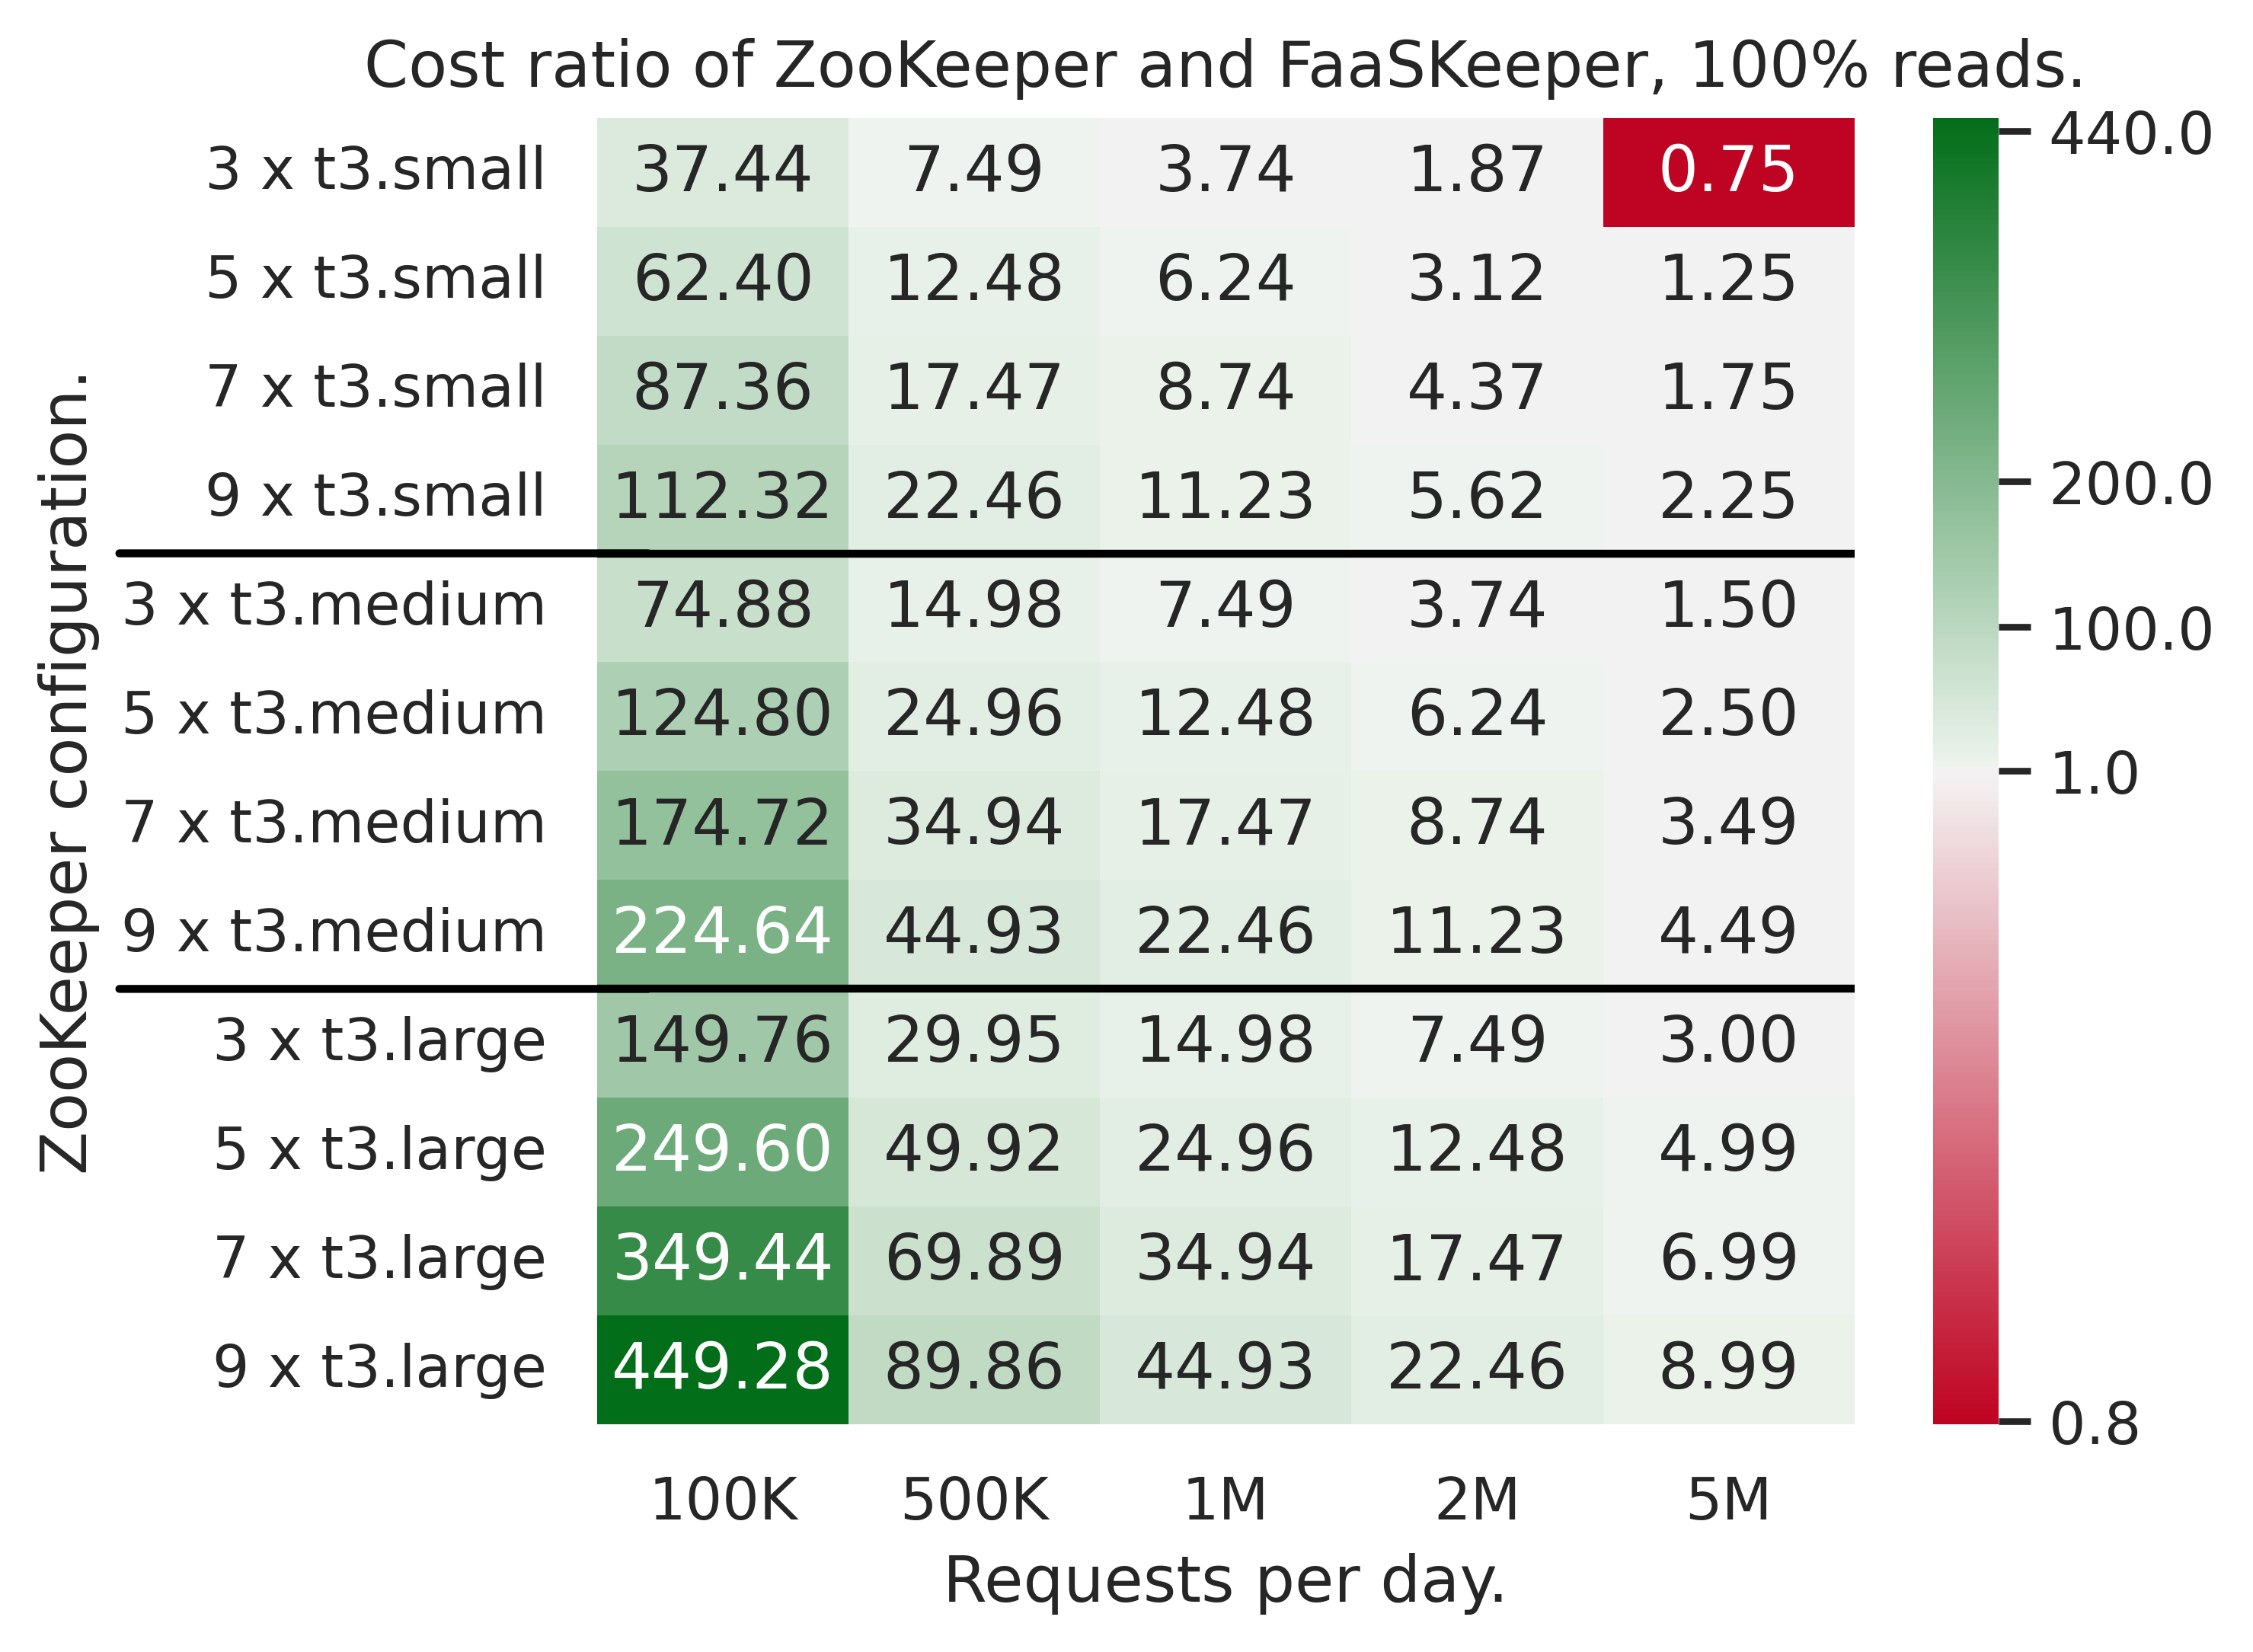

In [205]:

sns.set(rc={'figure.figsize':(6,4.5)})
#zk_vms = 3
t3_cost = {
    'small': 0.0208 * 24,
    'medium': 0.0416 * 24,
    'large': 0.0832 * 24
}        
#requests = [100, 250, 500, 750, 1000]
requests = [100, 500, 1000, 2000, 5000]
        
# 512 MB, 1 kB


results = []
labels = []

data = []
    
for size in ['small', 'medium', 'large']:
    for vms in [3, 5, 7, 9]:
        
        cost = 0.4 * 10**-6
        ratio = 1.0
        
        y_cost = list(map(lambda x : ratio * x * cost + (1-ratio)*total_cost(512,1)*x, [1000*x for x in requests]))
        zk_cost = [t3_cost[size] * vms] * len(y_cost)
        
        ratio = []
        for i in range(len(zk_cost)):
            ratio.append(zk_cost[i] / y_cost[i])
            data.append(ratio[-1])
        results.append(ratio)
        labels.append(f'{size}_{vms}')
        
data = np.array(data)
requests_labels = ['100K', '500K', '1M', '2M', '5M']

labs = []

    
for size in ['small', 'medium', 'large']:
    for vms in [3, 5, 7, 9]:
        labs.append(f'{vms} x t3.{size}')

matrix_df = pd.DataFrame(results,columns=requests_labels,index=labs)#cols)

from matplotlib.colors import TwoSlopeNorm
rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=40, sep=3, as_cmap=True)
print(data.min(),data.max())
divnorm = TwoSlopeNorm(vmin=data.min(), vcenter=1, vmax=data.max())

fig = sns.heatmap(matrix_df,
            #cmap='Blues',
            #cmap="PiYG",
              cmap=rdgn,
              norm=divnorm,
            cbar=True,
            cbar_kws={'ticks': [0.75, 1, 100, 200, 440], 'format': '%.1f'},
            annot=True,
            fmt='.2f',
            vmax=70)
fig.set_xlabel('Requests per day.')
fig.set_ylabel('ZooKeeper configuration.')
fig.set_title('Cost ratio of ZooKeeper and FaaSKeeper, 100% reads.')
#fig.set_clip_on(False)

fig.annotate('',
    xy=(-1.9, 4), xycoords='data',
    xytext=(100, 0), textcoords='offset points', color='black',annotation_clip=False,
    arrowprops=dict(arrowstyle="-", lw=1.5,shrinkA=0, shrinkB=0,color='black'))
fig.annotate('',
    xy=(-1.9, 8), xycoords='data',
    xytext=(100, 0), textcoords='offset points', color='black',annotation_clip=False,
    arrowprops=dict(arrowstyle="-", lw=1.5,shrinkA=0, shrinkB=0,color='black'))
low, high = ax.get_xlim()
print(low, high)
fig.hlines([4, 8], low-150, high+150, colors='black')
#fig.axhline(4, low-150, high+150)
plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("new_cost_plot_100.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

0.09692862457740234 58.15717474644142
0.0 10.0


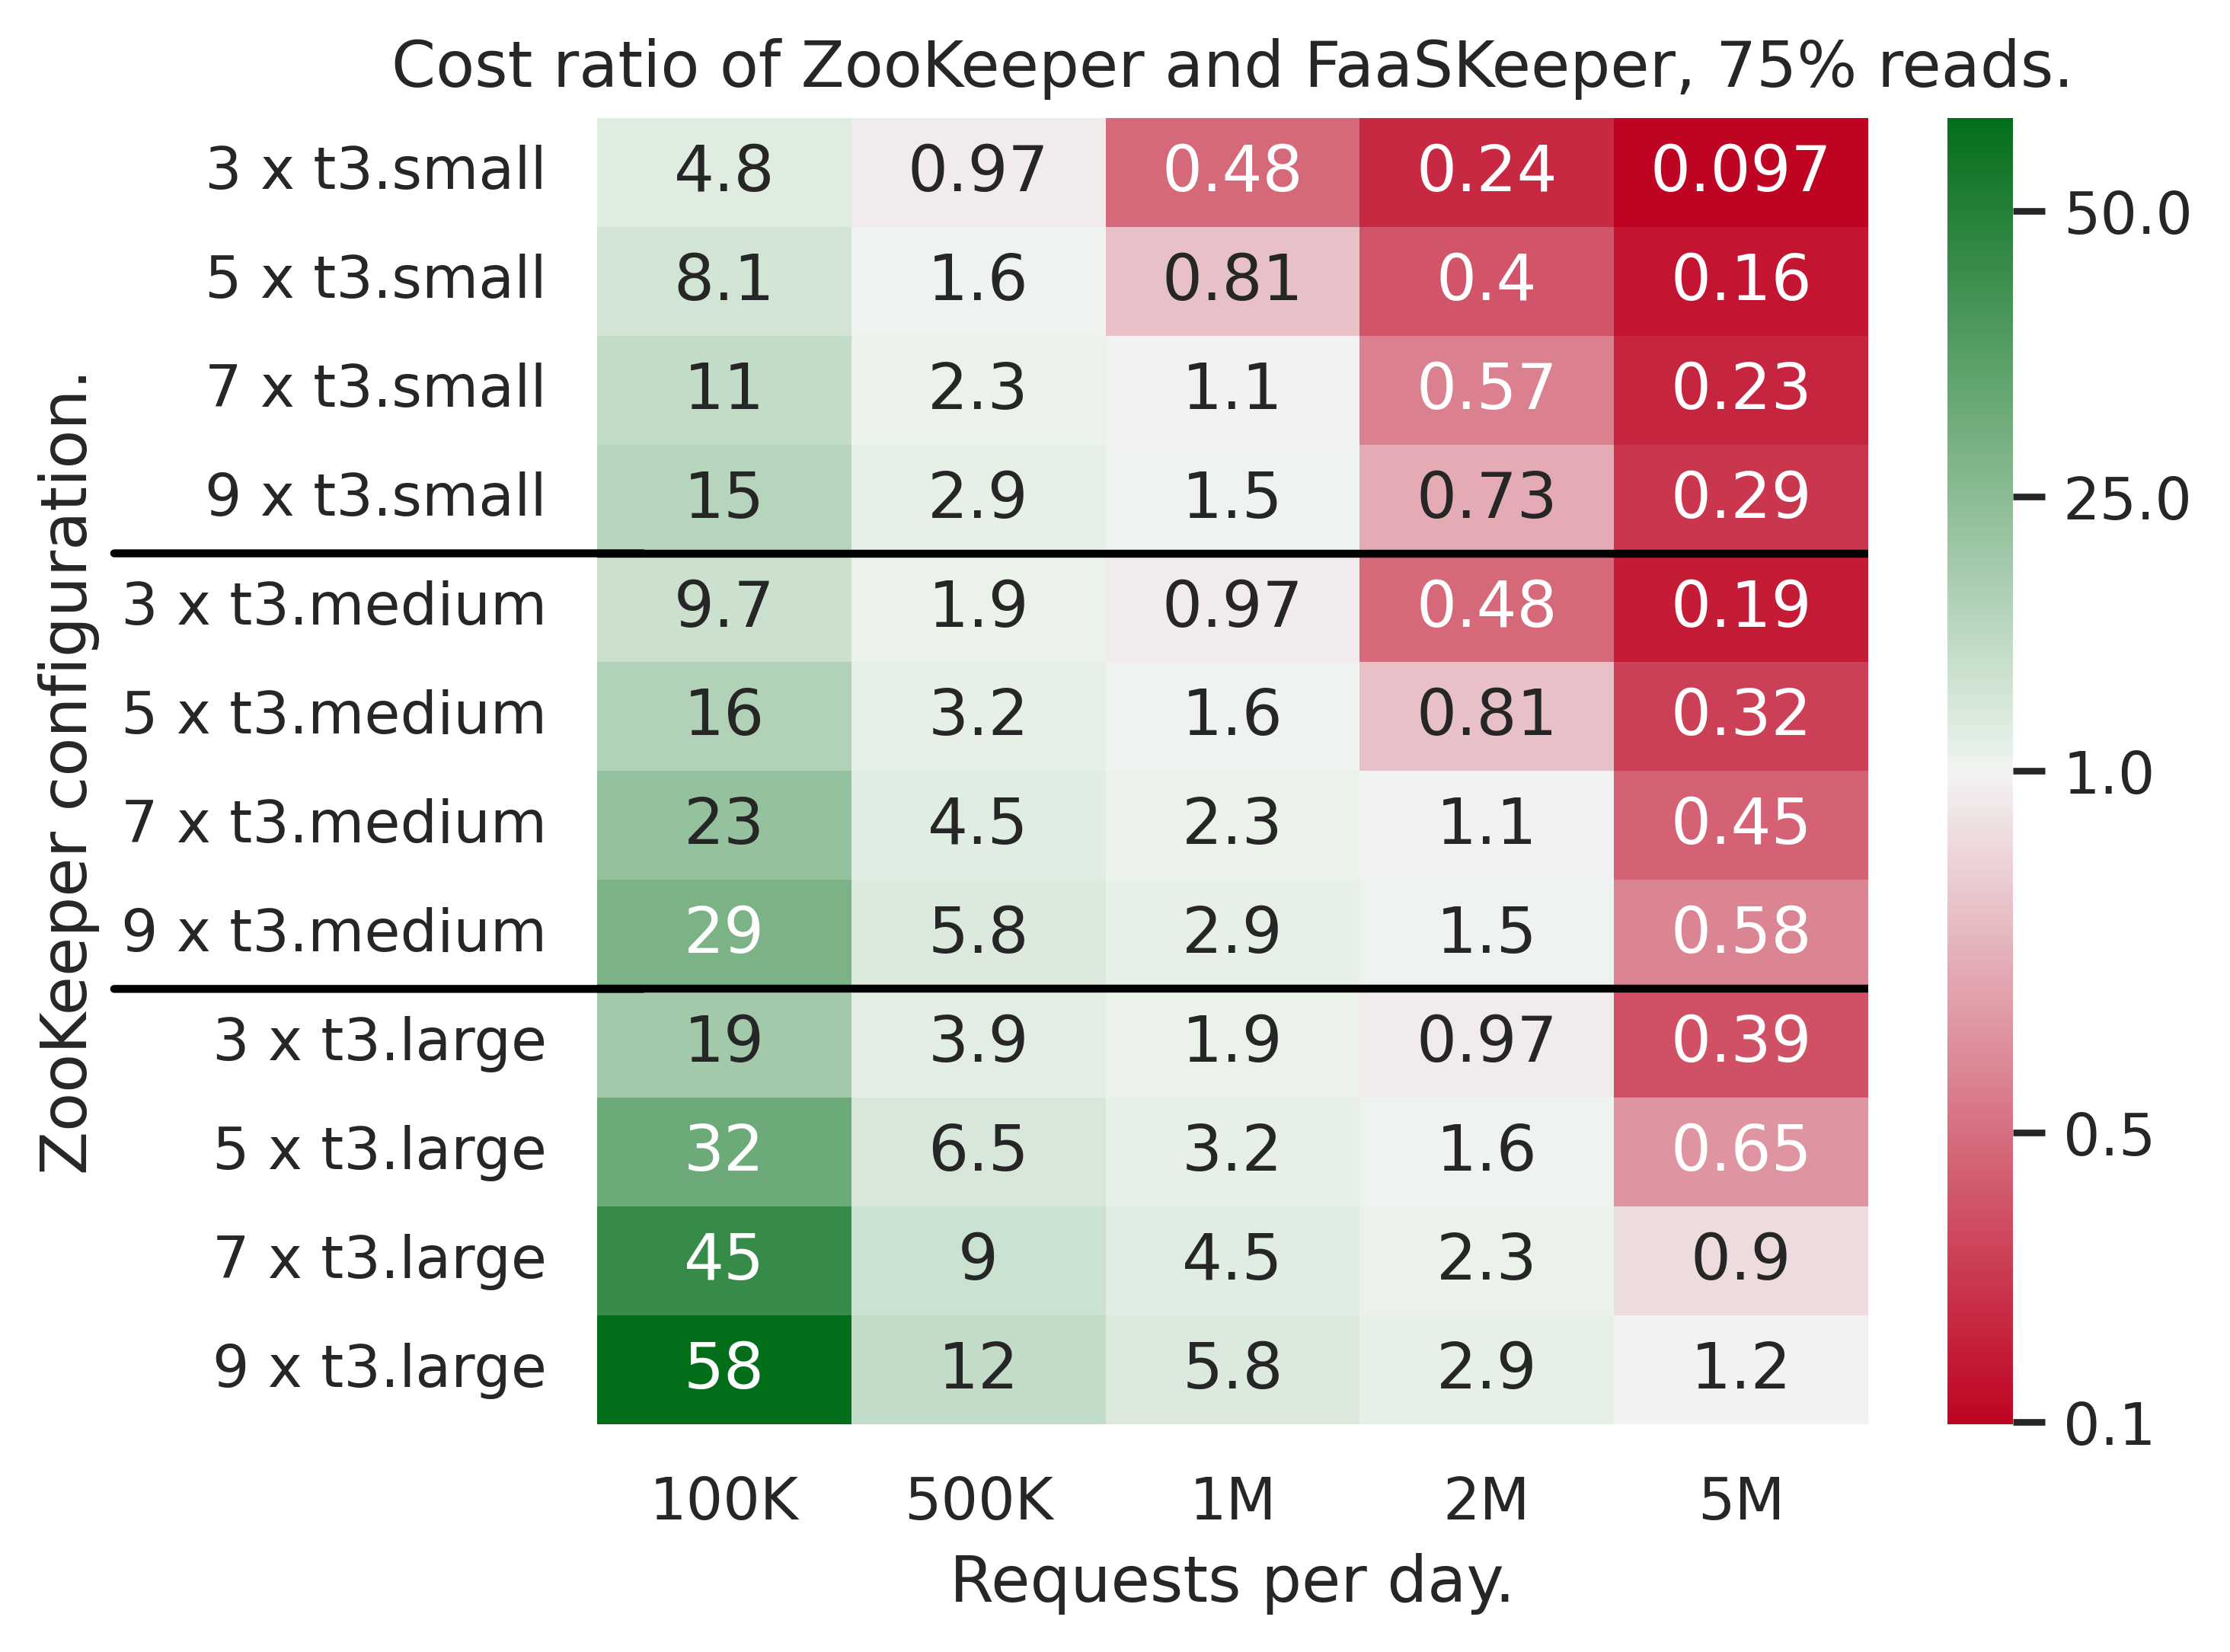

In [187]:

sns.set(rc={'figure.figsize':(6,4.5)})
#zk_vms = 3
t3_cost = {
    'small': 0.0208 * 24,
    'medium': 0.0416 * 24,
    'large': 0.0832 * 24
}        
#requests = [100, 250, 500, 750, 1000]
requests = [100, 500, 1000, 2000, 5000]
        
# 512 MB, 1 kB


results = []
labels = []

data = []
    
for size in ['small', 'medium', 'large']:
    for vms in [3, 5, 7, 9]:
        
        cost = 0.4 * 10**-6
        ratio = 0.75
        
        y_cost = list(map(lambda x : ratio * x * cost + (1-ratio)*total_cost(512,1)*x, [1000*x for x in requests]))
        zk_cost = [t3_cost[size] * vms] * len(y_cost)
        
        ratio = []
        for i in range(len(zk_cost)):
            ratio.append(zk_cost[i] / y_cost[i])
            data.append(ratio[-1])
        results.append(ratio)
        labels.append(f'{size}_{vms}')
        
data = np.array(data)
requests_labels = ['100K', '500K', '1M', '2M', '5M']

labs = []

    
for size in ['small', 'medium', 'large']:
    for vms in [3, 5, 7, 9]:
        labs.append(f'{vms} x t3.{size}')

matrix_df = pd.DataFrame(results,columns=requests_labels,index=labs)#cols)

from matplotlib.colors import TwoSlopeNorm
rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=40, sep=3, as_cmap=True)
print(data.min(),data.max())
divnorm = TwoSlopeNorm(vmin=data.min(), vcenter=1, vmax=data.max())

fig = sns.heatmap(matrix_df,
            #cmap='Blues',
            #cmap="PiYG",
              cmap=rdgn,
              norm=divnorm,
            cbar=True,
            cbar_kws={'ticks': [0.1, 0.5, 1, 25, 50], 'format': '%.1f'},
            annot=True,
            fmt='.2g',
            vmax=70)
fig.set_xlabel('Requests per day.')
fig.set_ylabel('ZooKeeper configuration.')
fig.set_title('Cost ratio of ZooKeeper and FaaSKeeper, 75% reads.')
#fig.set_clip_on(False)

fig.annotate('',
    xy=(-1.9, 4), xycoords='data',
    xytext=(100, 0), textcoords='offset points', color='black',annotation_clip=False,
    arrowprops=dict(arrowstyle="-", lw=1.5,shrinkA=0, shrinkB=0,color='black'))
fig.annotate('',
    xy=(-1.9, 8), xycoords='data',
    xytext=(100, 0), textcoords='offset points', color='black',annotation_clip=False,
    arrowprops=dict(arrowstyle="-", lw=1.5,shrinkA=0, shrinkB=0,color='black'))
low, high = ax.get_xlim()
print(low, high)
fig.hlines([4, 8], low-150, high+150, colors='black')
#fig.axhline(4, low-150, high+150)
plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("new_cost_plot_75.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

0.20292084373293098 121.7525062397586
0.0 10.0


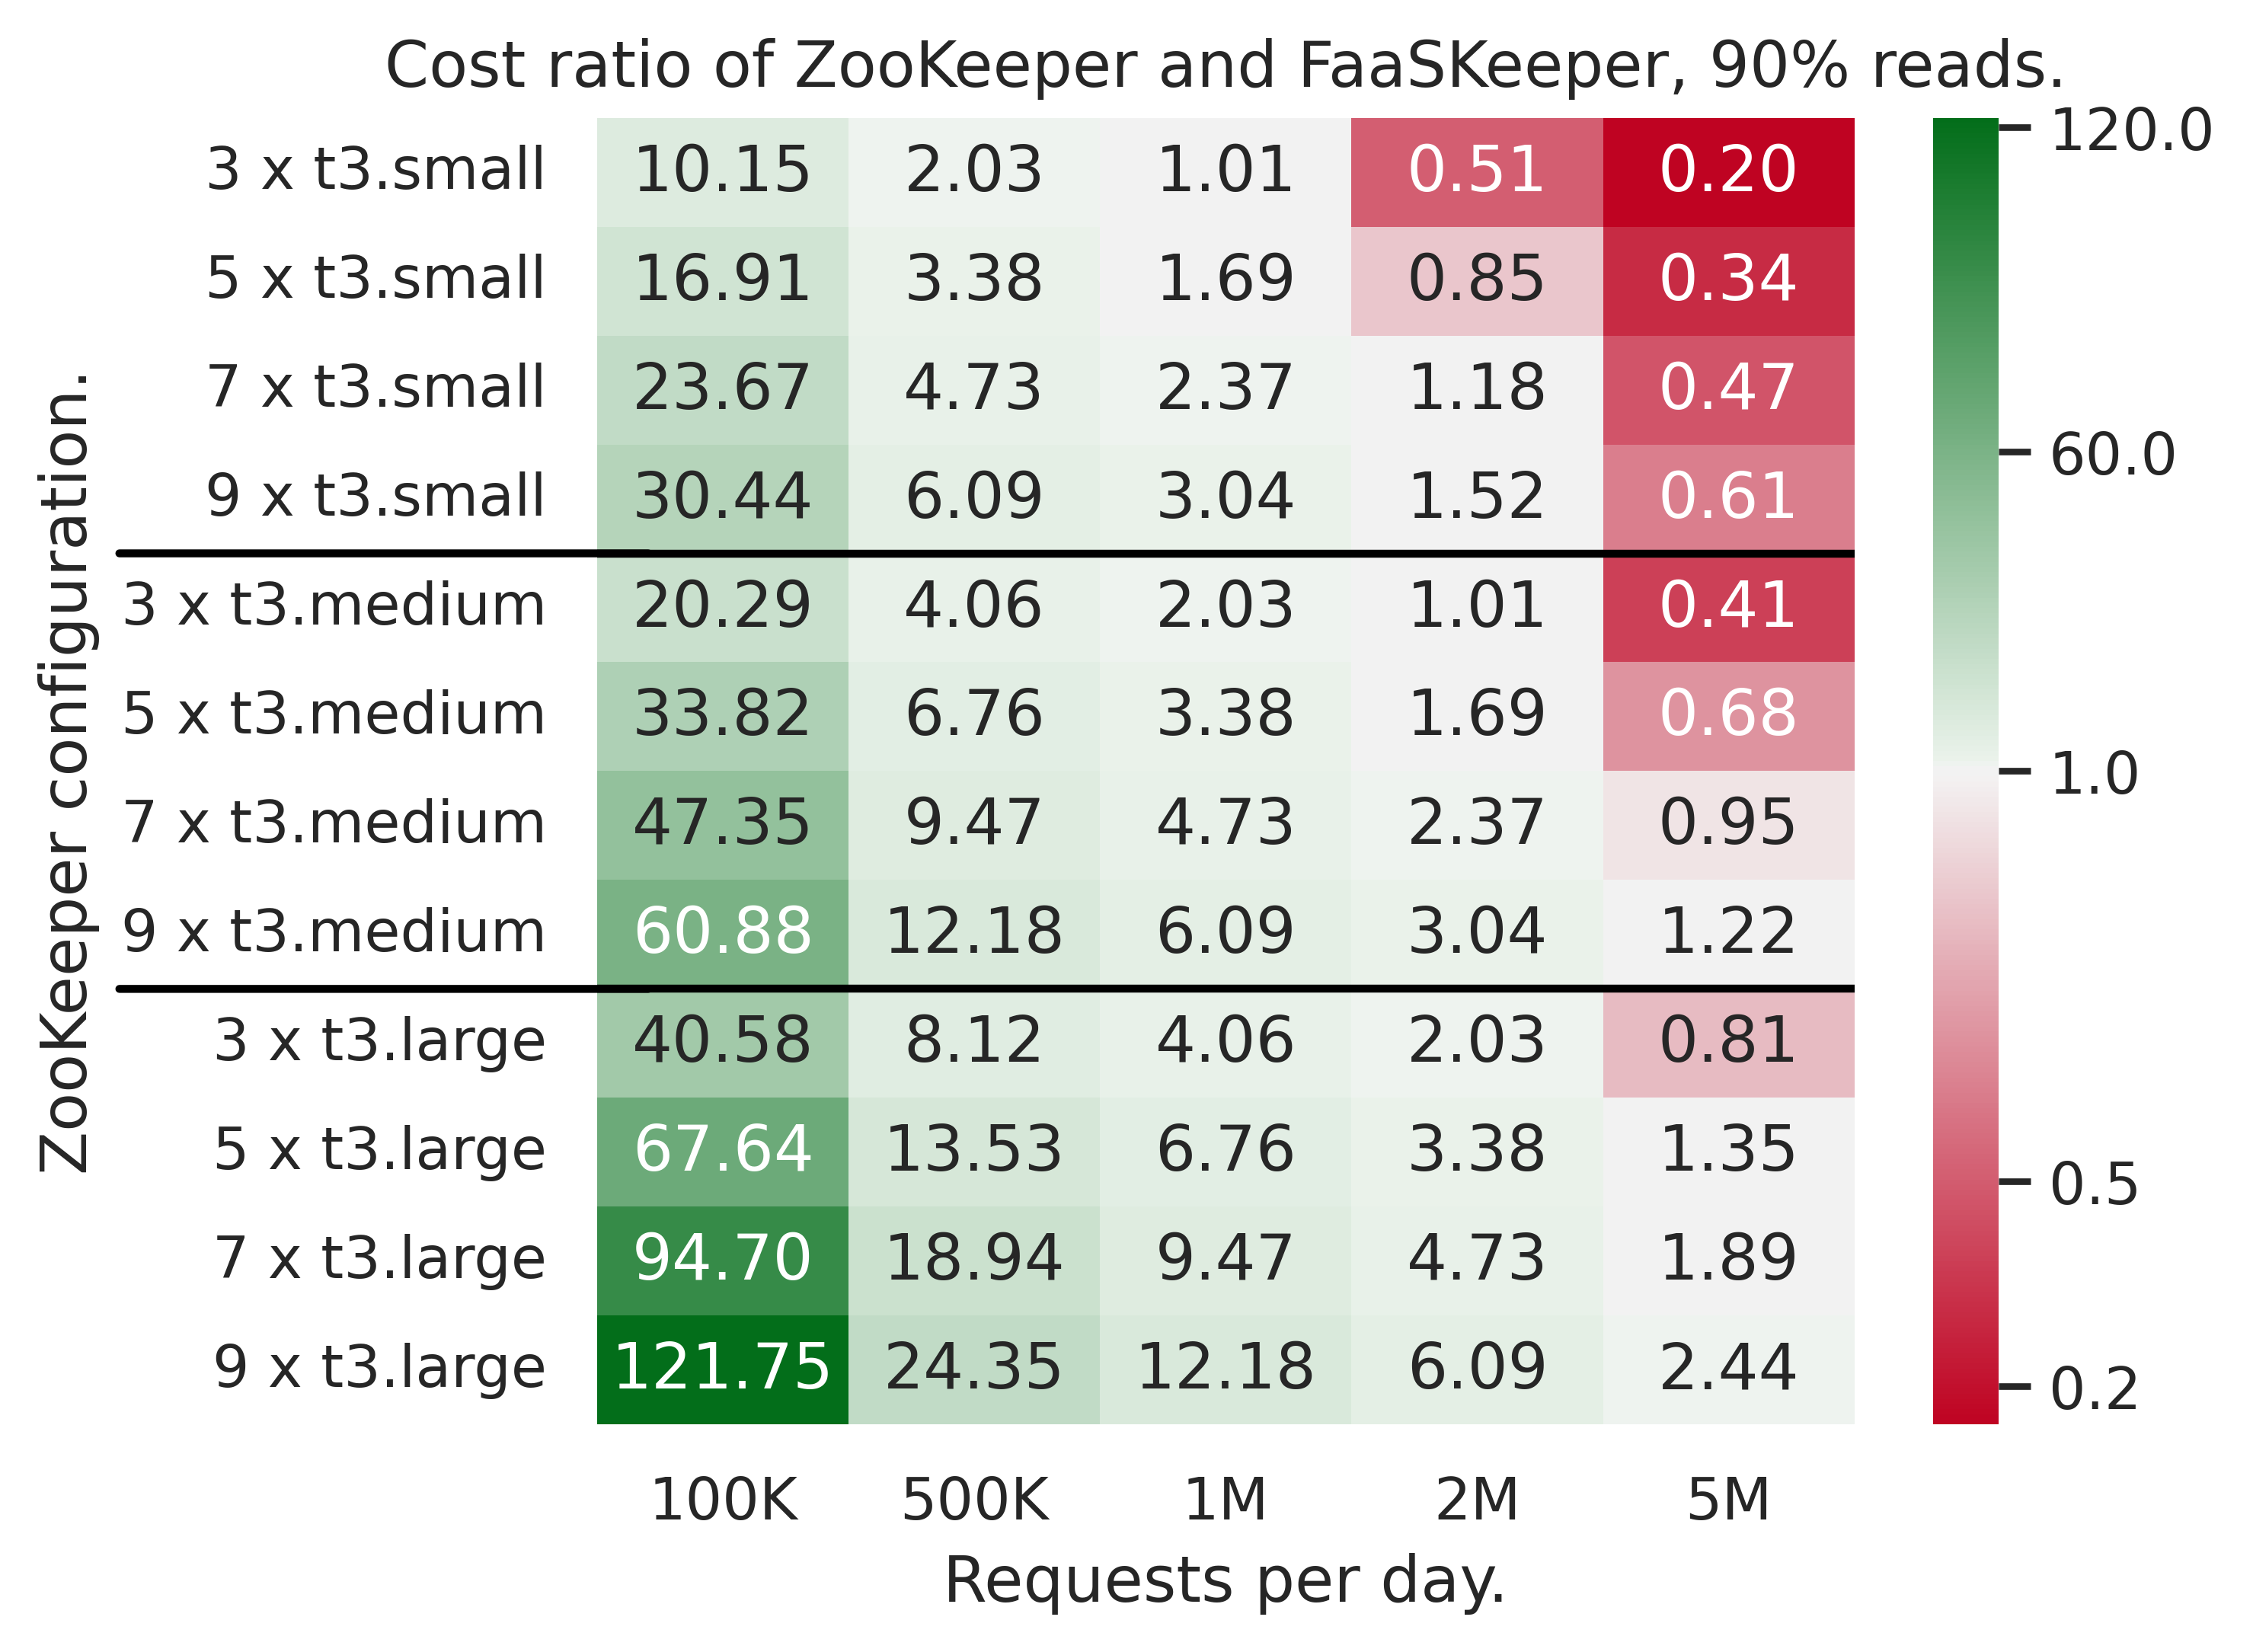

In [190]:

sns.set(rc={'figure.figsize':(6,4.5)})
#zk_vms = 3
t3_cost = {
    'small': 0.0208 * 24,
    'medium': 0.0416 * 24,
    'large': 0.0832 * 24
}        
#requests = [100, 250, 500, 750, 1000]
requests = [100, 500, 1000, 2000, 5000]
        
# 512 MB, 1 kB


results = []
labels = []

data = []
    
for size in ['small', 'medium', 'large']:
    for vms in [3, 5, 7, 9]:
        
        cost = 0.4 * 10**-6
        ratio = 0.9
        
        y_cost = list(map(lambda x : ratio * x * cost + (1-ratio)*total_cost(512,1)*x, [1000*x for x in requests]))
        zk_cost = [t3_cost[size] * vms] * len(y_cost)
        
        ratio = []
        for i in range(len(zk_cost)):
            ratio.append(zk_cost[i] / y_cost[i])
            data.append(ratio[-1])
        results.append(ratio)
        labels.append(f'{size}_{vms}')
        
data = np.array(data)
requests_labels = ['100K', '500K', '1M', '2M', '5M']

labs = []

    
for size in ['small', 'medium', 'large']:
    for vms in [3, 5, 7, 9]:
        labs.append(f'{vms} x t3.{size}')

matrix_df = pd.DataFrame(results,columns=requests_labels,index=labs)#cols)

from matplotlib.colors import TwoSlopeNorm
rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=40, sep=3, as_cmap=True)
print(data.min(),data.max())
divnorm = TwoSlopeNorm(vmin=data.min(), vcenter=1, vmax=data.max())

fig = sns.heatmap(matrix_df,
            #cmap='Blues',
            #cmap="PiYG",
              cmap=rdgn,
              norm=divnorm,
            cbar=True,
            cbar_kws={'ticks': [0.25, 0.5, 1, 60, 120], 'format': '%.1f'},
            annot=True,
            fmt='2.2f',
            vmax=70)
fig.set_xlabel('Requests per day.')
fig.set_ylabel('ZooKeeper configuration.')
fig.set_title('Cost ratio of ZooKeeper and FaaSKeeper, 90% reads.')
#fig.set_clip_on(False)

fig.annotate('',
    xy=(-1.9, 4), xycoords='data',
    xytext=(100, 0), textcoords='offset points', color='black',annotation_clip=False,
    arrowprops=dict(arrowstyle="-", lw=1.5,shrinkA=0, shrinkB=0,color='black'))
fig.annotate('',
    xy=(-1.9, 8), xycoords='data',
    xytext=(100, 0), textcoords='offset points', color='black',annotation_clip=False,
    arrowprops=dict(arrowstyle="-", lw=1.5,shrinkA=0, shrinkB=0,color='black'))
low, high = ax.get_xlim()
print(low, high)
fig.hlines([4, 8], low, high, colors='black')
#fig.axhline(4, low-150, high+150)
plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("new_cost_plot_90.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

# cost for hybrid

In [65]:
import numpy as np
import pandas as pd
import os
from os.path import join, pardir
DATA_DIR = join(pardir, pardir, 'data', 'write_new_algorithm')

dfs = []
for mem in [512, 1024, 2048]:
    
    for size in [4, 1024, 65536, 131072, 256000]:
        df = pd.read_csv(join(DATA_DIR, f'persistent_{size}_{mem}_processed.csv'), index_col=0)
        df['size'] = size / 1024
        
        #print(df)
        # data is broken :-(
        #df = df.loc[df['memory'] == mem]
        #df = df.groupby(['memory', 'function']).head(150).reset_index(drop=True)
        #if df.shape[0] > 200:
        #    print(size, mem)
        dfs.append(df)
        
        
dynamo_df = pd.concat(dfs)
dynamo_df['system'] = 'persistent'
dynamo_df['gbs'] = dynamo_df['billed_time'] * dynamo_df['memory'] / 1024.0 / 1000
#print(dynamo_df)
#print(dynamo_df.groupby(['function', 'memory', 'size']).median()['gbs'])
#for memory in [512, 1024, 2048]

data = {}
for f in ['writer', 'distributor']:
    data[f] = {}
    for m in [512, 1024, 2048]:
        data[f][m] = []

for name, group in dynamo_df.groupby(['function', 'memory', 'size']):
    data[name[0]][name[1]].append(group['gbs'].median())
print(data)

import numpy as np
from sklearn.linear_model import LinearRegression

x = np.array([5, 15, 25, 35, 45, 55]).reshape((-1, 1))
y = np.array([5, 20, 14, 32, 22, 38])
#model = LinearRegression().fit(x, y)
#r_sq = model.score(x, y)
#print('coefficient of determination:', r_sq)

coefficients_classic = {}

sizes = np.array([4, 1024, 65536, 131072, 256000],dtype=np.float64)
sizes /= 1024.0
x = sizes.reshape((-1, 1))
for f in ['writer', 'distributor']:
    coefficients_classic[f] = {}
    for m in [512, 1024, 2048]:
        y = data[f][m]
        model = LinearRegression().fit(x, y)
        print(f, m, model.score(x, y))
        print(f, m, model.intercept_)
        print(f, m, model.coef_)
        coefficients_classic[f][m] = (model.coef_[0], model.intercept_)

{'writer': {512: [0.0175, 0.016, 0.0365, 0.0615, 0.112], 1024: [0.031, 0.036, 0.0475, 0.08, 0.126], 2048: [0.064, 0.064, 0.096, 0.134, 0.206]}, 'distributor': {512: [0.0305, 0.0305, 0.046, 0.0375, 0.0705], 1024: [0.066, 0.068, 0.087, 0.076, 0.1255], 2048: [0.126, 0.128, 0.174, 0.15, 0.266]}}
writer 512 0.9963644803002555
writer 512 0.01496649396738299
writer 512 [0.00038074]
writer 1024 0.9871717634364325
writer 1024 0.030832908798636094
writer 1024 [0.00037547]
writer 2048 0.9989504094929981
writer 2048 0.06237247868431657
writer 2048 [0.00056915]
distributor 512 0.8323095564870369
distributor 512 0.030133583324175074
distributor 512 [0.00014522]
distributor 1024 0.8340794980685053
distributor 1024 0.06564661347094553
distributor 1024 [0.00021279]
distributor 2048 0.8446768499321637
distributor 2048 0.12385090662481799
distributor 2048 [0.00050732]


In [61]:
import numpy as np
import pandas as pd
import os
from os.path import join, pardir
DATA_DIR = join(pardir, pardir, 'data', 'write_new_algorithm', 'keyvalue')

dfs = []
for mem in [512, 1024, 2048]:
    
    for size in [4, 128, 256, 512, 1024,2048,4096]:
        df = pd.read_csv(join(DATA_DIR, f'persistent_{size}_{mem}_processed.csv'), index_col=0)
        df['size'] = size / 1024
        
        #print(df)
        # data is broken :-(
        #df = df.loc[df['memory'] == mem]
        #df = df.groupby(['memory', 'function']).head(150).reset_index(drop=True)
        #if df.shape[0] > 200:
        #    print(size, mem)
        dfs.append(df)
        
        
dynamo_df = pd.concat(dfs)
dynamo_df['system'] = 'persistent'
dynamo_df['gbs'] = dynamo_df['billed_time'] * dynamo_df['memory'] / 1024.0 / 1000
print(dynamo_df)
#print(dynamo_df.groupby(['function', 'memory', 'size']).median()['gbs'])
#for memory in [512, 1024, 2048]

data = {}
for f in ['writer', 'distributor']:
    data[f] = {}
    for m in [512, 1024, 2048]:
        data[f][m] = []

for name, group in dynamo_df.groupby(['function', 'memory', 'size']):
    data[name[0]][name[1]].append(group['gbs'].median())
print(data)

import numpy as np
from sklearn.linear_model import LinearRegression

x = np.array([5, 15, 25, 35, 45, 55]).reshape((-1, 1))
y = np.array([5, 20, 14, 32, 22, 38])
#model = LinearRegression().fit(x, y)
#r_sq = model.score(x, y)
#print('coefficient of determination:', r_sq)

coefficients = {}

sizes = np.array([4, 128, 256, 512, 1024,2048,4096],dtype=np.float64)
sizes /= 1024.0
x = sizes.reshape((-1, 1))
for f in ['writer', 'distributor']:
    coefficients[f] = {}
    for m in [512, 1024, 2048]:
        y = data[f][m]
        model = LinearRegression().fit(x, y)
        print(f, m, model.score(x, y))
        print(f, m, model.intercept_)
        print(f, m, model.coef_)
        coefficients[f][m] = (model.coef_[0], model.intercept_)

                                  request   time  billed_time  memory  \
0    a41cd615-0c35-5688-a6f7-8ba9a245aad7  42.76           43     512   
1    d0c809ba-e881-5071-ba96-540646f194fc  29.66           30     512   
2    1d29af01-850c-5681-8542-f2bd2b63dcca  26.05           27     512   
3    aa2bf827-5c95-5397-b167-a59bf2fa15b3  31.52           32     512   
4    d77cea66-1709-59a3-9a89-b7dab96693c2  26.10           27     512   
..                                    ...    ...          ...     ...   
746  30ed80b4-b749-5ea2-863e-dd080b2f1da2  27.03           28    2048   
747  276a6f4c-ae18-536a-b4ea-32f0127d6449  24.13           25    2048   
748  650d0b46-564b-501d-ad03-56faea2e0f26  23.93           24    2048   
749  3807f496-3ecc-594b-b648-a92a82a9ac82  25.22           26    2048   
750  53c48000-eee4-5886-b297-ddbc52ac06ab  46.33           47    2048   

     used_memory                                  read  write     function  \
0             75  a41cd615-0c35-5688-a6f7-8ba

In [74]:
import math
# PUT, COPY, POST, LIST requests (per 1,000 requests)
def write_s3(s):
    return  5*10**-6
def read_s3(s):
    return  0.4*10**-6
def write_dynamodb(s):
    return math.ceil(s) * 1.25 * 10**-6
def read_dynamodb(s):
    return math.ceil(s/4.0) * 0.25 * 10**-6
# FIFO Queues (per Million requests) 0.5
def sqs(s):
    return math.ceil(s/64.0) * 0.5 * 10**-6

lambda_const = 1.66667 * 10**-5

def writer_classic(m, s):
    return lambda_const*(coefficients['writer'][m][0] * s + coefficients['writer'][m][1]) + 0.2 * 10**-6
def distributor_classic(m, s):
    return lambda_const*(coefficients['distributor'][m][0] * s + coefficients['distributor'][m][1]) + 0.2 * 10**-6

#def total_cost(m, s):
    #return 2 * sqs(s) + 3 * write_dynamodb(1) + read_dynamodb(1) + write_s3(s) + writer(m, s) + distributor(m, s)
#    return 2 * sqs(s) + 3 * write_dynamodb(1) + read_dynamodb(1) + write_dynamodb(s) + writer_classic(m, s) + distributor(m, s)

def total_cost_classic(m, s):
    #return 2 * sqs(s) + 3 * write_dynamodb(1) + read_dynamodb(1) + write_s3(s) + writer(m, s) + distributor(m, s)
    return 2 * sqs(s) + 3 * write_dynamodb(1) + read_dynamodb(1) + write_s3(s) + distributor_classic(m, s) + writer_classic(m, s)


In [93]:
import math
# PUT, COPY, POST, LIST requests (per 1,000 requests)
def write_s3(s):
    return  5*10**-6
def read_s3(s):
    return  0.4*10**-6
def write_dynamodb(s):
    return math.ceil(s) * 1.25 * 10**-6
def read_dynamodb(s):
    return math.ceil(s/4.0) * 0.25 * 10**-6
# FIFO Queues (per Million requests) 0.5
def sqs(s):
    return math.ceil(s/64.0) * 0.5 * 10**-6

lambda_const = 1.66667 * 10**-5

#def writer(m, s):
#    return lambda_const*(coefficients['writer'][m][0] * s + coefficients['writer'][m][1]) + 0.2 * 10**-6
#def distributor(m, s):
#    return lambda_const*(coefficients['distributor'][m][0] * s + coefficients['distributor'][m][1]) + 0.2 * 10**-6
def writer(m, s):
    #return lambda_const*(0.065) + 0.2 * 10**-6
    return lambda_const*(0.016) + 0.2 * 10**-6
def distributor(m, s):
    #return lambda_const*(0.06) + 0.2 * 10**-6
    return lambda_const*(0.0155) + 0.2 * 10**-6

#def total_cost(m, s):
#    #return 2 * sqs(s) + 3 * write_dynamodb(1) + read_dynamodb(1) + write_s3(s) + writer(m, s) + distributor(m, s)
#    return 2 * sqs(s) + 3 * write_dynamodb(1) + read_dynamodb(1) + write_dynamodb(s) + writer(m, s) + distributor(m, s)

def total_cost(m, s):
    #return 2 * sqs(s) + 3 * write_dynamodb(1) + read_dynamodb(1) + write_s3(s) + writer(m, s) + distributor(m, s)
    return 2 * sqs(s) + 3 * write_dynamodb(1) + read_dynamodb(1) + write_dynamodb(s) + writer(m, s) + distributor(m, s)


In [99]:
print(total_cost_classic(512, 1)*10**5)
print(round(total_cost(512, 1)*100000,2))
print(total_cost(512, 1)*10**5)

1.1160435374209536
0.72
0.7175001049999999


[ 59.904    11.9808    5.9904    2.9952    1.19808  99.84     19.968
   9.984     4.992     1.9968  139.776    27.9552   13.9776    6.9888
   2.79552 179.712    35.9424   17.9712    8.9856    3.59424 119.808
  23.9616   11.9808    5.9904    2.39616 199.68     39.936    19.968
   9.984     3.9936  279.552    55.9104   27.9552   13.9776    5.59104
 359.424    71.8848   35.9424   17.9712    7.18848 239.616    47.9232
  23.9616   11.9808    4.79232 399.36     79.872    39.936    19.968
   7.9872  559.104   111.8208   55.9104   27.9552   11.18208 718.848
 143.7696   71.8848   35.9424   14.37696]
1.1980799999999998 1 718.8480000000001
0.0 5.0


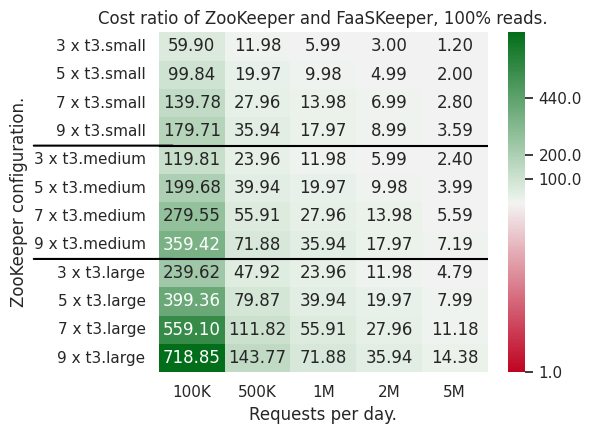

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.ticker as ticker

sns.set(rc={'figure.figsize':(6,4.5)})
#zk_vms = 3
t3_cost = {
    'small': 0.0208 * 24,
    'medium': 0.0416 * 24,
    'large': 0.0832 * 24
}        
#requests = [100, 250, 500, 750, 1000]
requests = [100, 500, 1000, 2000, 5000]
        
# 512 MB, 1 kB


results = []
labels = []

data = []
    
for size in ['small', 'medium', 'large']:
    for vms in [3, 5, 7, 9]:
        
        #cost = 0.4 * 10**-6
        cost = 0.25 * 10**-6
        ratio = 1.0
        
        y_cost = list(map(lambda x : ratio * x * cost + (1-ratio)*total_cost(512,1)*x, [1000*x for x in requests]))
        zk_cost = [t3_cost[size] * vms] * len(y_cost)
        
        ratio = []
        for i in range(len(zk_cost)):
            ratio.append(zk_cost[i] / y_cost[i])
            data.append(ratio[-1])
        results.append(ratio)
        labels.append(f'{size}_{vms}')
        
data = np.array(data)
print(data)
requests_labels = ['100K', '500K', '1M', '2M', '5M']

labs = []

    
for size in ['small', 'medium', 'large']:
    for vms in [3, 5, 7, 9]:
        labs.append(f'{vms} x t3.{size}')

matrix_df = pd.DataFrame(results,columns=requests_labels,index=labs)#cols)

from matplotlib.colors import TwoSlopeNorm
rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=40, sep=3, as_cmap=True)
print(data.min(),1,data.max())
divnorm = TwoSlopeNorm(vmin=1, vcenter=data.min(), vmax=data.max())

fig = sns.heatmap(matrix_df,
            #cmap='Blues',
            #cmap="PiYG",
              cmap=rdgn,
              norm=divnorm,
            cbar=True,
            cbar_kws={'ticks': [0.75, 1, 100, 200, 440], 'format': '%.1f'},
            annot=True,
            fmt='.2f',
            vmax=70)
fig.set_xlabel('Requests per day.')
fig.set_ylabel('ZooKeeper configuration.')
fig.set_title('Cost ratio of ZooKeeper and FaaSKeeper, 100% reads.')
#fig.set_clip_on(False)

fig.annotate('',
    xy=(-1.9, 4), xycoords='data',
    xytext=(100, 0), textcoords='offset points', color='black',annotation_clip=False,
    arrowprops=dict(arrowstyle="-", lw=1.5,shrinkA=0, shrinkB=0,color='black'))
fig.annotate('',
    xy=(-1.9, 8), xycoords='data',
    xytext=(100, 0), textcoords='offset points', color='black',annotation_clip=False,
    arrowprops=dict(arrowstyle="-", lw=1.5,shrinkA=0, shrinkB=0,color='black'))
low, high = fig.get_xlim()
print(low, high)
fig.hlines([4, 8], low-150, high+150, colors='black')
#fig.axhline(4, low-150, high+150)
plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("new_cost_plot_100_hybrid.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

0.3177930680442736 190.67584082656418
0.0 5.0


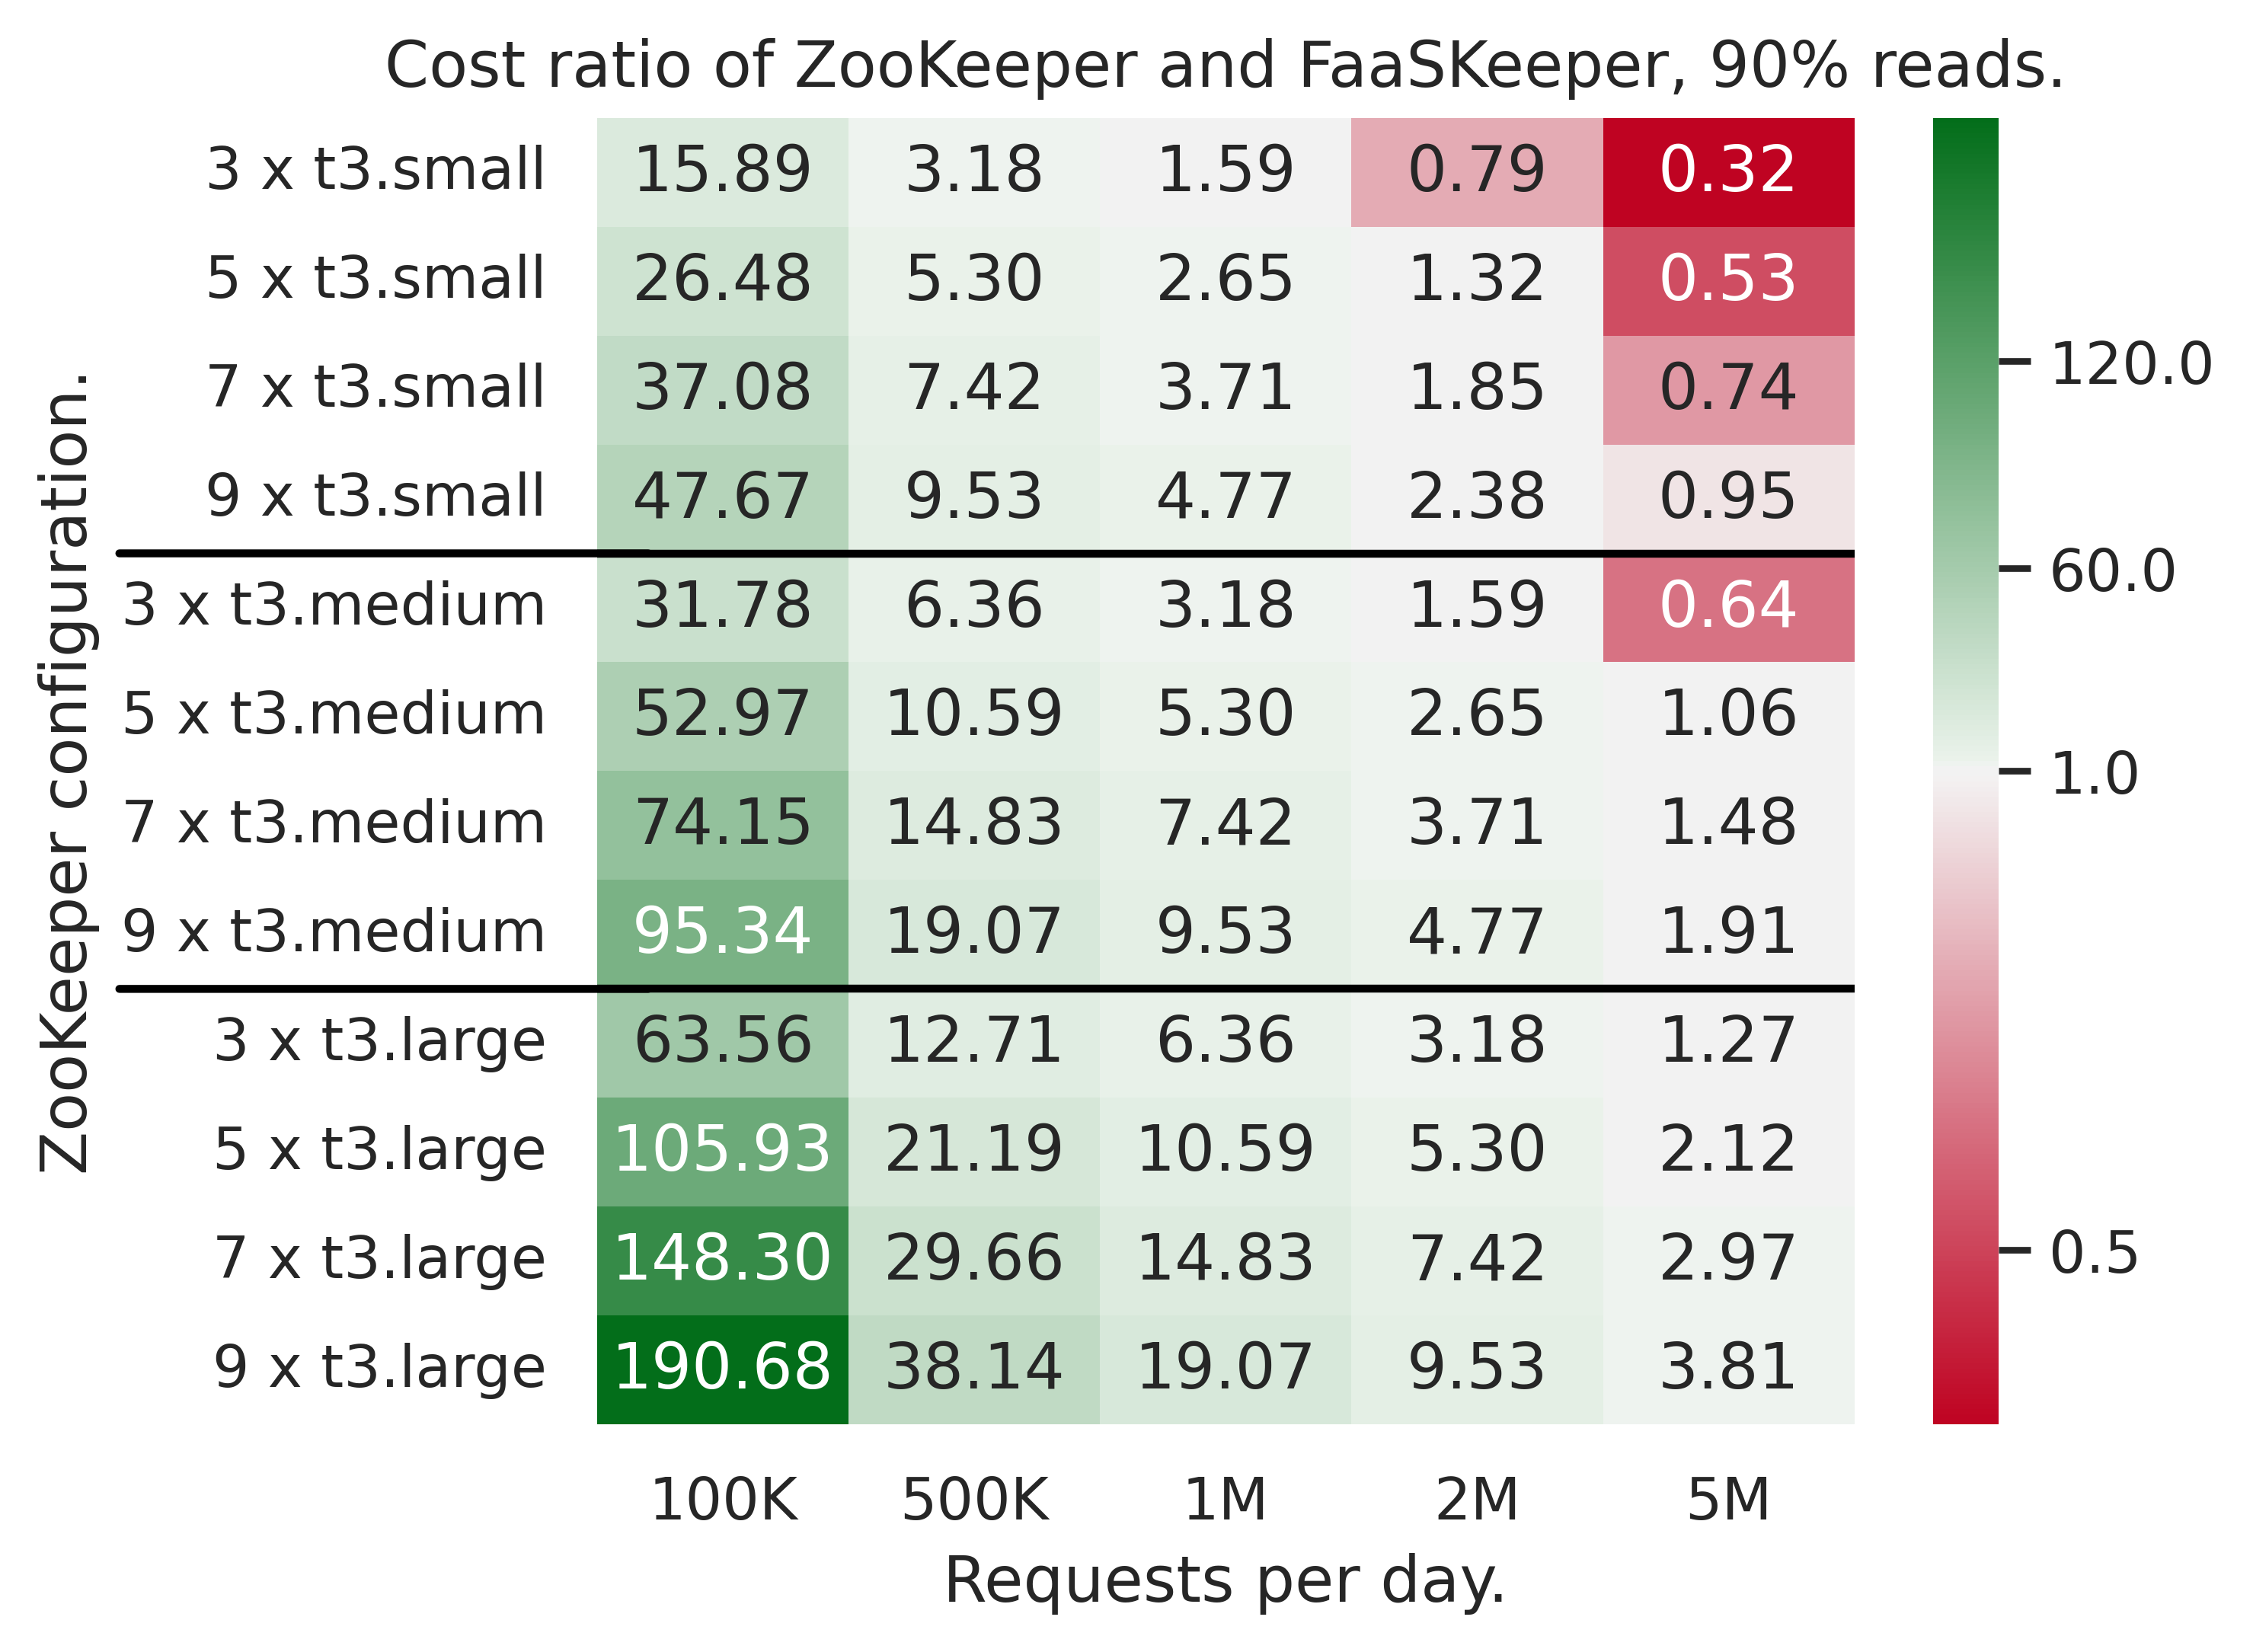

In [95]:

sns.set(rc={'figure.figsize':(6,4.5)})
#zk_vms = 3
t3_cost = {
    'small': 0.0208 * 24,
    'medium': 0.0416 * 24,
    'large': 0.0832 * 24
}        
#requests = [100, 250, 500, 750, 1000]
requests = [100, 500, 1000, 2000, 5000]
        
# 512 MB, 1 kB


results = []
labels = []

data = []
    
for size in ['small', 'medium', 'large']:
    for vms in [3, 5, 7, 9]:
        
        #cost = 0.4 * 10**-6
        cost = 0.25 * 10**-6
        ratio = 0.9
        
        y_cost = list(map(lambda x : ratio * x * cost + (1-ratio)*total_cost(512,1)*x, [1000*x for x in requests]))
        zk_cost = [t3_cost[size] * vms] * len(y_cost)
        
        ratio = []
        for i in range(len(zk_cost)):
            ratio.append(zk_cost[i] / y_cost[i])
            data.append(ratio[-1])
        results.append(ratio)
        labels.append(f'{size}_{vms}')
        
data = np.array(data)
requests_labels = ['100K', '500K', '1M', '2M', '5M']

labs = []

    
for size in ['small', 'medium', 'large']:
    for vms in [3, 5, 7, 9]:
        labs.append(f'{vms} x t3.{size}')

matrix_df = pd.DataFrame(results,columns=requests_labels,index=labs)#cols)

from matplotlib.colors import TwoSlopeNorm
rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=40, sep=3, as_cmap=True)
print(data.min(),data.max())
divnorm = TwoSlopeNorm(vmin=data.min(), vcenter=1, vmax=data.max())

fig = sns.heatmap(matrix_df,
            #cmap='Blues',
            #cmap="PiYG",
              cmap=rdgn,
              norm=divnorm,
            cbar=True,
            cbar_kws={'ticks': [0.25, 0.5, 1, 60, 120], 'format': '%.1f'},
            annot=True,
            fmt='2.2f',
            vmax=70)
fig.set_xlabel('Requests per day.')
fig.set_ylabel('ZooKeeper configuration.')
fig.set_title('Cost ratio of ZooKeeper and FaaSKeeper, 90% reads.')
#fig.set_clip_on(False)

fig.annotate('',
    xy=(-1.9, 4), xycoords='data',
    xytext=(100, 0), textcoords='offset points', color='black',annotation_clip=False,
    arrowprops=dict(arrowstyle="-", lw=1.5,shrinkA=0, shrinkB=0,color='black'))
fig.annotate('',
    xy=(-1.9, 8), xycoords='data',
    xytext=(100, 0), textcoords='offset points', color='black',annotation_clip=False,
    arrowprops=dict(arrowstyle="-", lw=1.5,shrinkA=0, shrinkB=0,color='black'))
low, high = fig.get_xlim()
print(low, high)
fig.hlines([4, 8], low, high, colors='black')
#fig.axhline(4, low-150, high+150)
plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("new_cost_plot_90_hybrid.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

0.15117726703645043 90.70636022187027
0.0 5.0


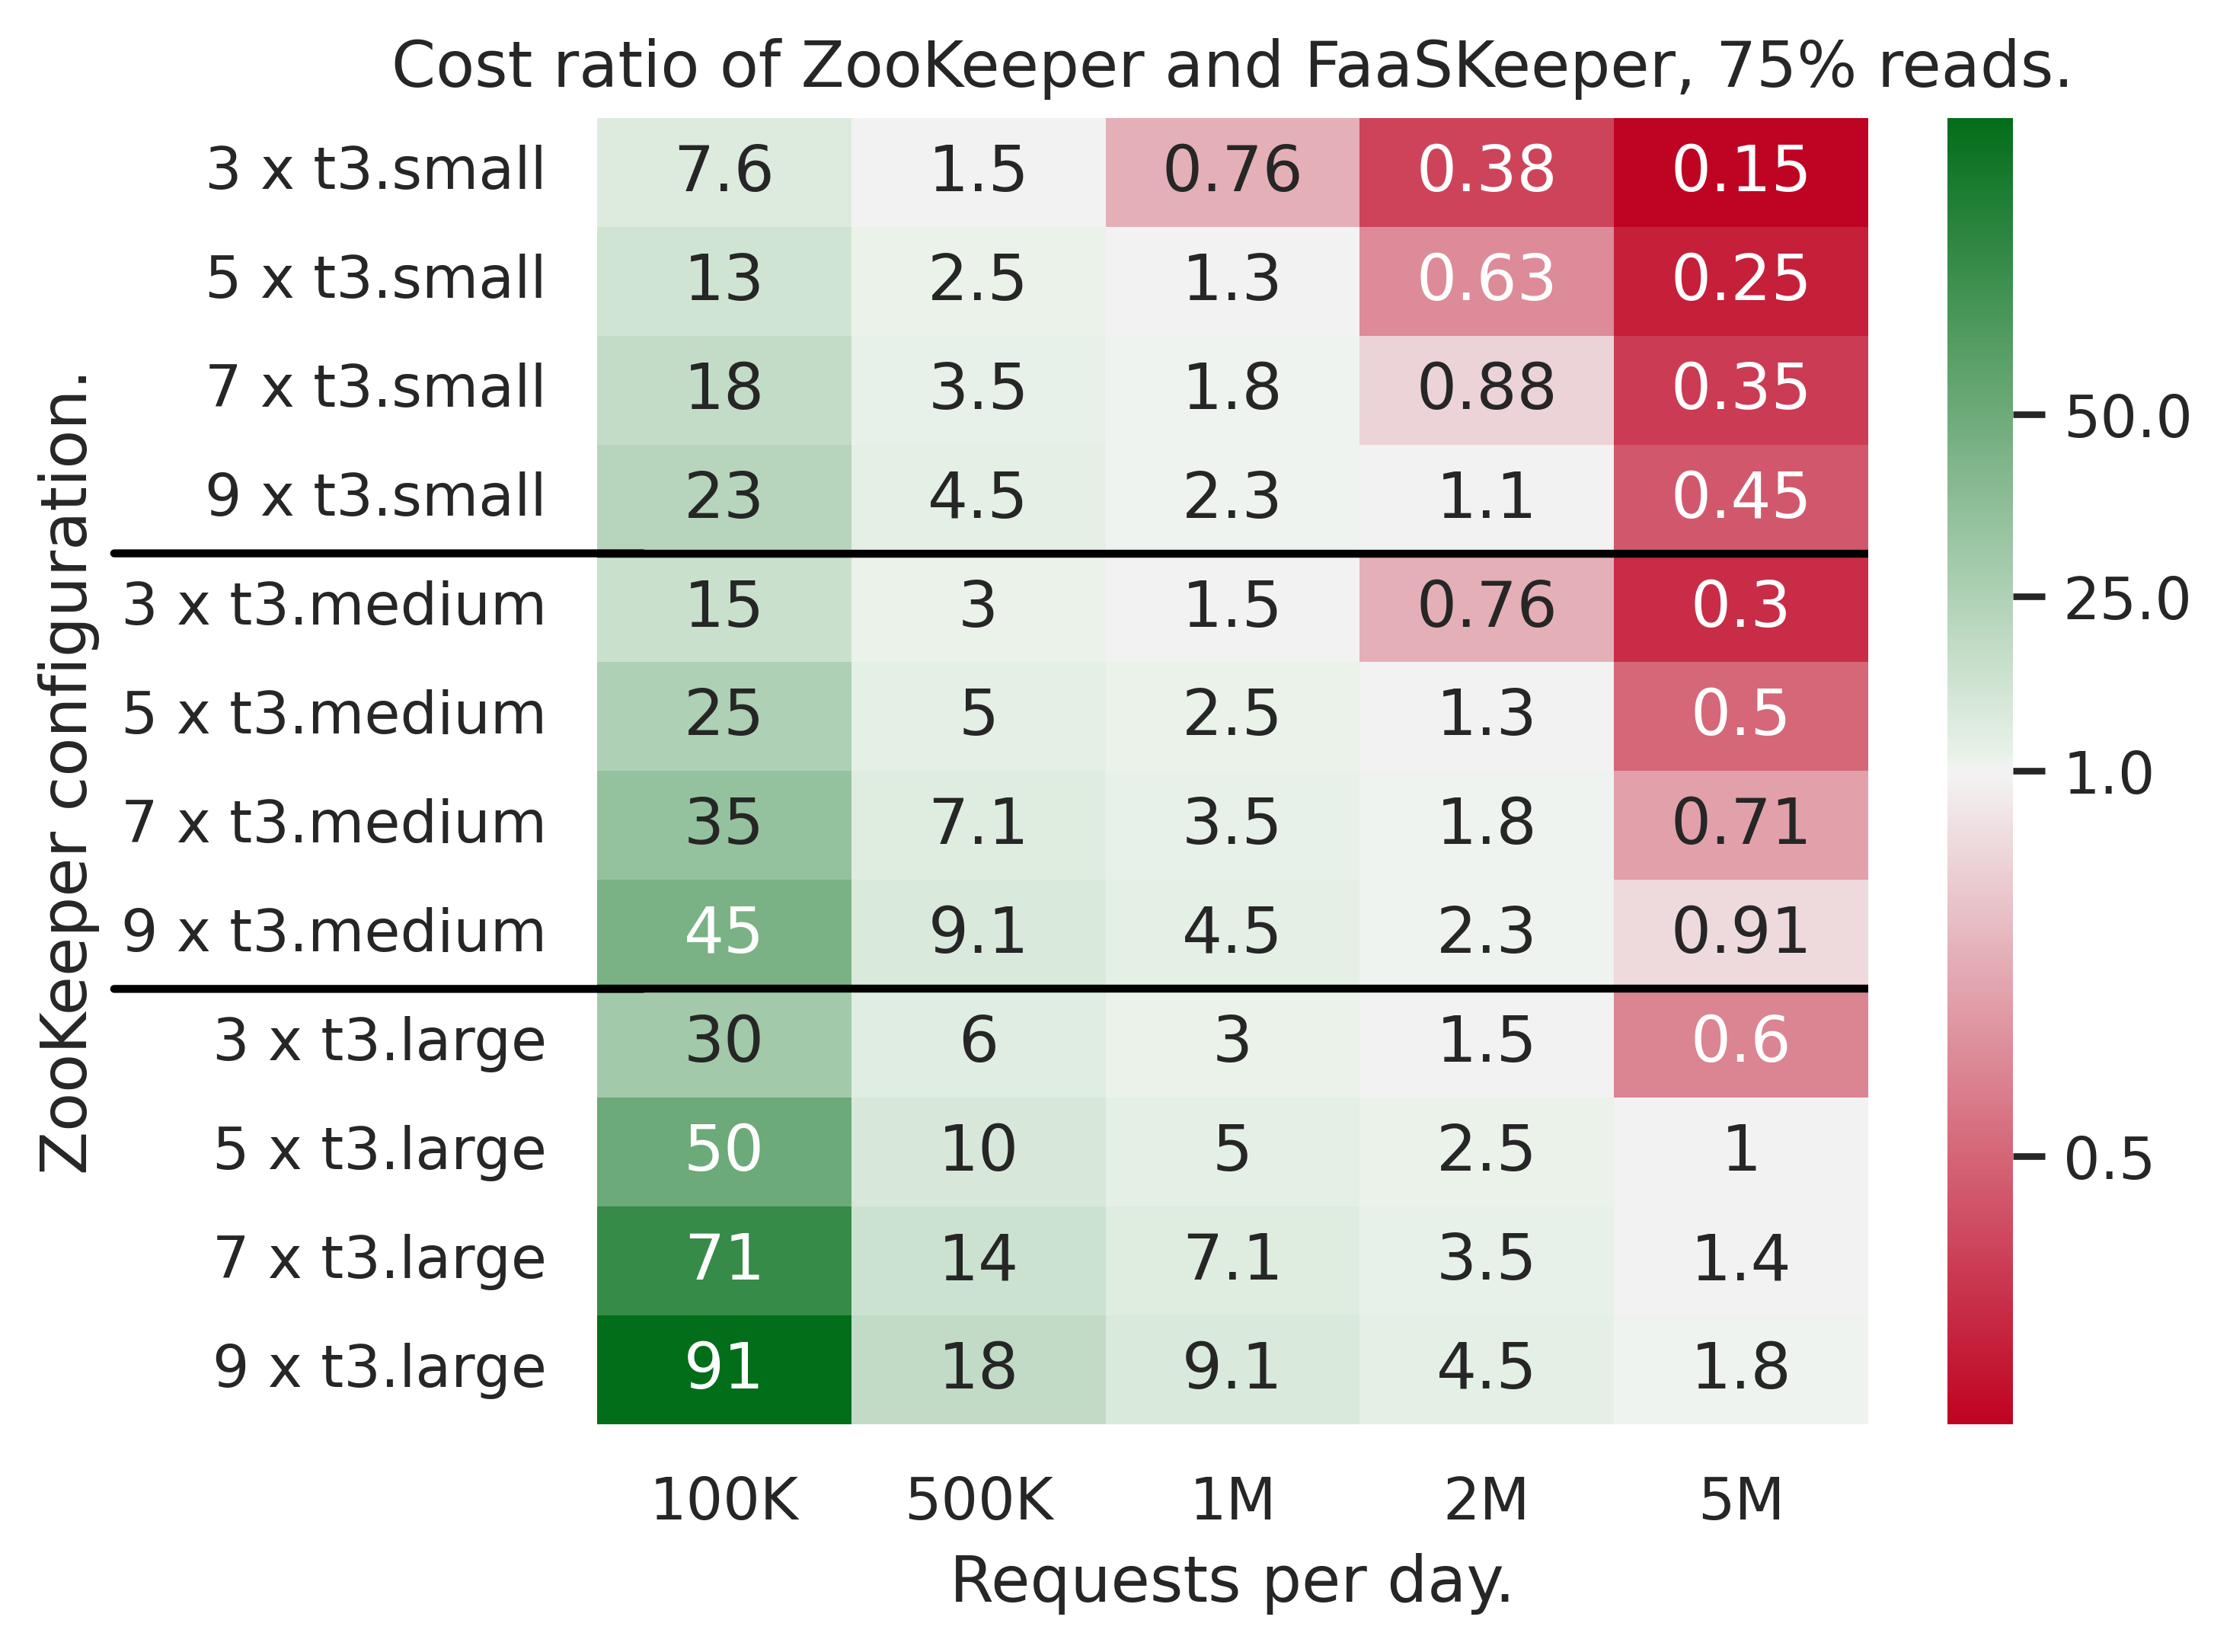

In [96]:

sns.set(rc={'figure.figsize':(6,4.5)})
#zk_vms = 3
t3_cost = {
    'small': 0.0208 * 24,
    'medium': 0.0416 * 24,
    'large': 0.0832 * 24
}        
#requests = [100, 250, 500, 750, 1000]
requests = [100, 500, 1000, 2000, 5000]
        
# 512 MB, 1 kB


results = []
labels = []

data = []
    
for size in ['small', 'medium', 'large']:
    for vms in [3, 5, 7, 9]:
        
        #cost = 0.4 * 10**-6
        cost = 0.25 * 10**-6
        ratio = 0.75
        
        y_cost = list(map(lambda x : ratio * x * cost + (1-ratio)*total_cost(512,1)*x, [1000*x for x in requests]))
        zk_cost = [t3_cost[size] * vms] * len(y_cost)
        
        ratio = []
        for i in range(len(zk_cost)):
            ratio.append(zk_cost[i] / y_cost[i])
            data.append(ratio[-1])
        results.append(ratio)
        labels.append(f'{size}_{vms}')
        
data = np.array(data)
requests_labels = ['100K', '500K', '1M', '2M', '5M']

labs = []

    
for size in ['small', 'medium', 'large']:
    for vms in [3, 5, 7, 9]:
        labs.append(f'{vms} x t3.{size}')

matrix_df = pd.DataFrame(results,columns=requests_labels,index=labs)#cols)

from matplotlib.colors import TwoSlopeNorm
rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=40, sep=3, as_cmap=True)
print(data.min(),data.max())
divnorm = TwoSlopeNorm(vmin=data.min(), vcenter=1, vmax=data.max())

fig = sns.heatmap(matrix_df,
            #cmap='Blues',
            #cmap="PiYG",
              cmap=rdgn,
              norm=divnorm,
            cbar=True,
            cbar_kws={'ticks': [0.1, 0.5, 1, 25, 50], 'format': '%.1f'},
            annot=True,
            fmt='.2g',
            vmax=70)
fig.set_xlabel('Requests per day.')
fig.set_ylabel('ZooKeeper configuration.')
fig.set_title('Cost ratio of ZooKeeper and FaaSKeeper, 75% reads.')
#fig.set_clip_on(False)

fig.annotate('',
    xy=(-1.9, 4), xycoords='data',
    xytext=(100, 0), textcoords='offset points', color='black',annotation_clip=False,
    arrowprops=dict(arrowstyle="-", lw=1.5,shrinkA=0, shrinkB=0,color='black'))
fig.annotate('',
    xy=(-1.9, 8), xycoords='data',
    xytext=(100, 0), textcoords='offset points', color='black',annotation_clip=False,
    arrowprops=dict(arrowstyle="-", lw=1.5,shrinkA=0, shrinkB=0,color='black'))
low, high = fig.get_xlim()
print(low, high)
fig.hlines([4, 8], low-150, high+150, colors='black')
#fig.axhline(4, low-150, high+150)
plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("new_cost_plot_hybrid_75.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

[ 59.904    11.9808    5.9904    2.9952    1.19808 179.712    35.9424
  17.9712    8.9856    3.59424 119.808    23.9616   11.9808    5.9904
   2.39616 359.424    71.8848   35.9424   17.9712    7.18848 239.616
  47.9232   23.9616   11.9808    4.79232 718.848   143.7696   71.8848
  35.9424   14.37696]
1.1980799999999998 1 718.8480000000001
0.0 5.0


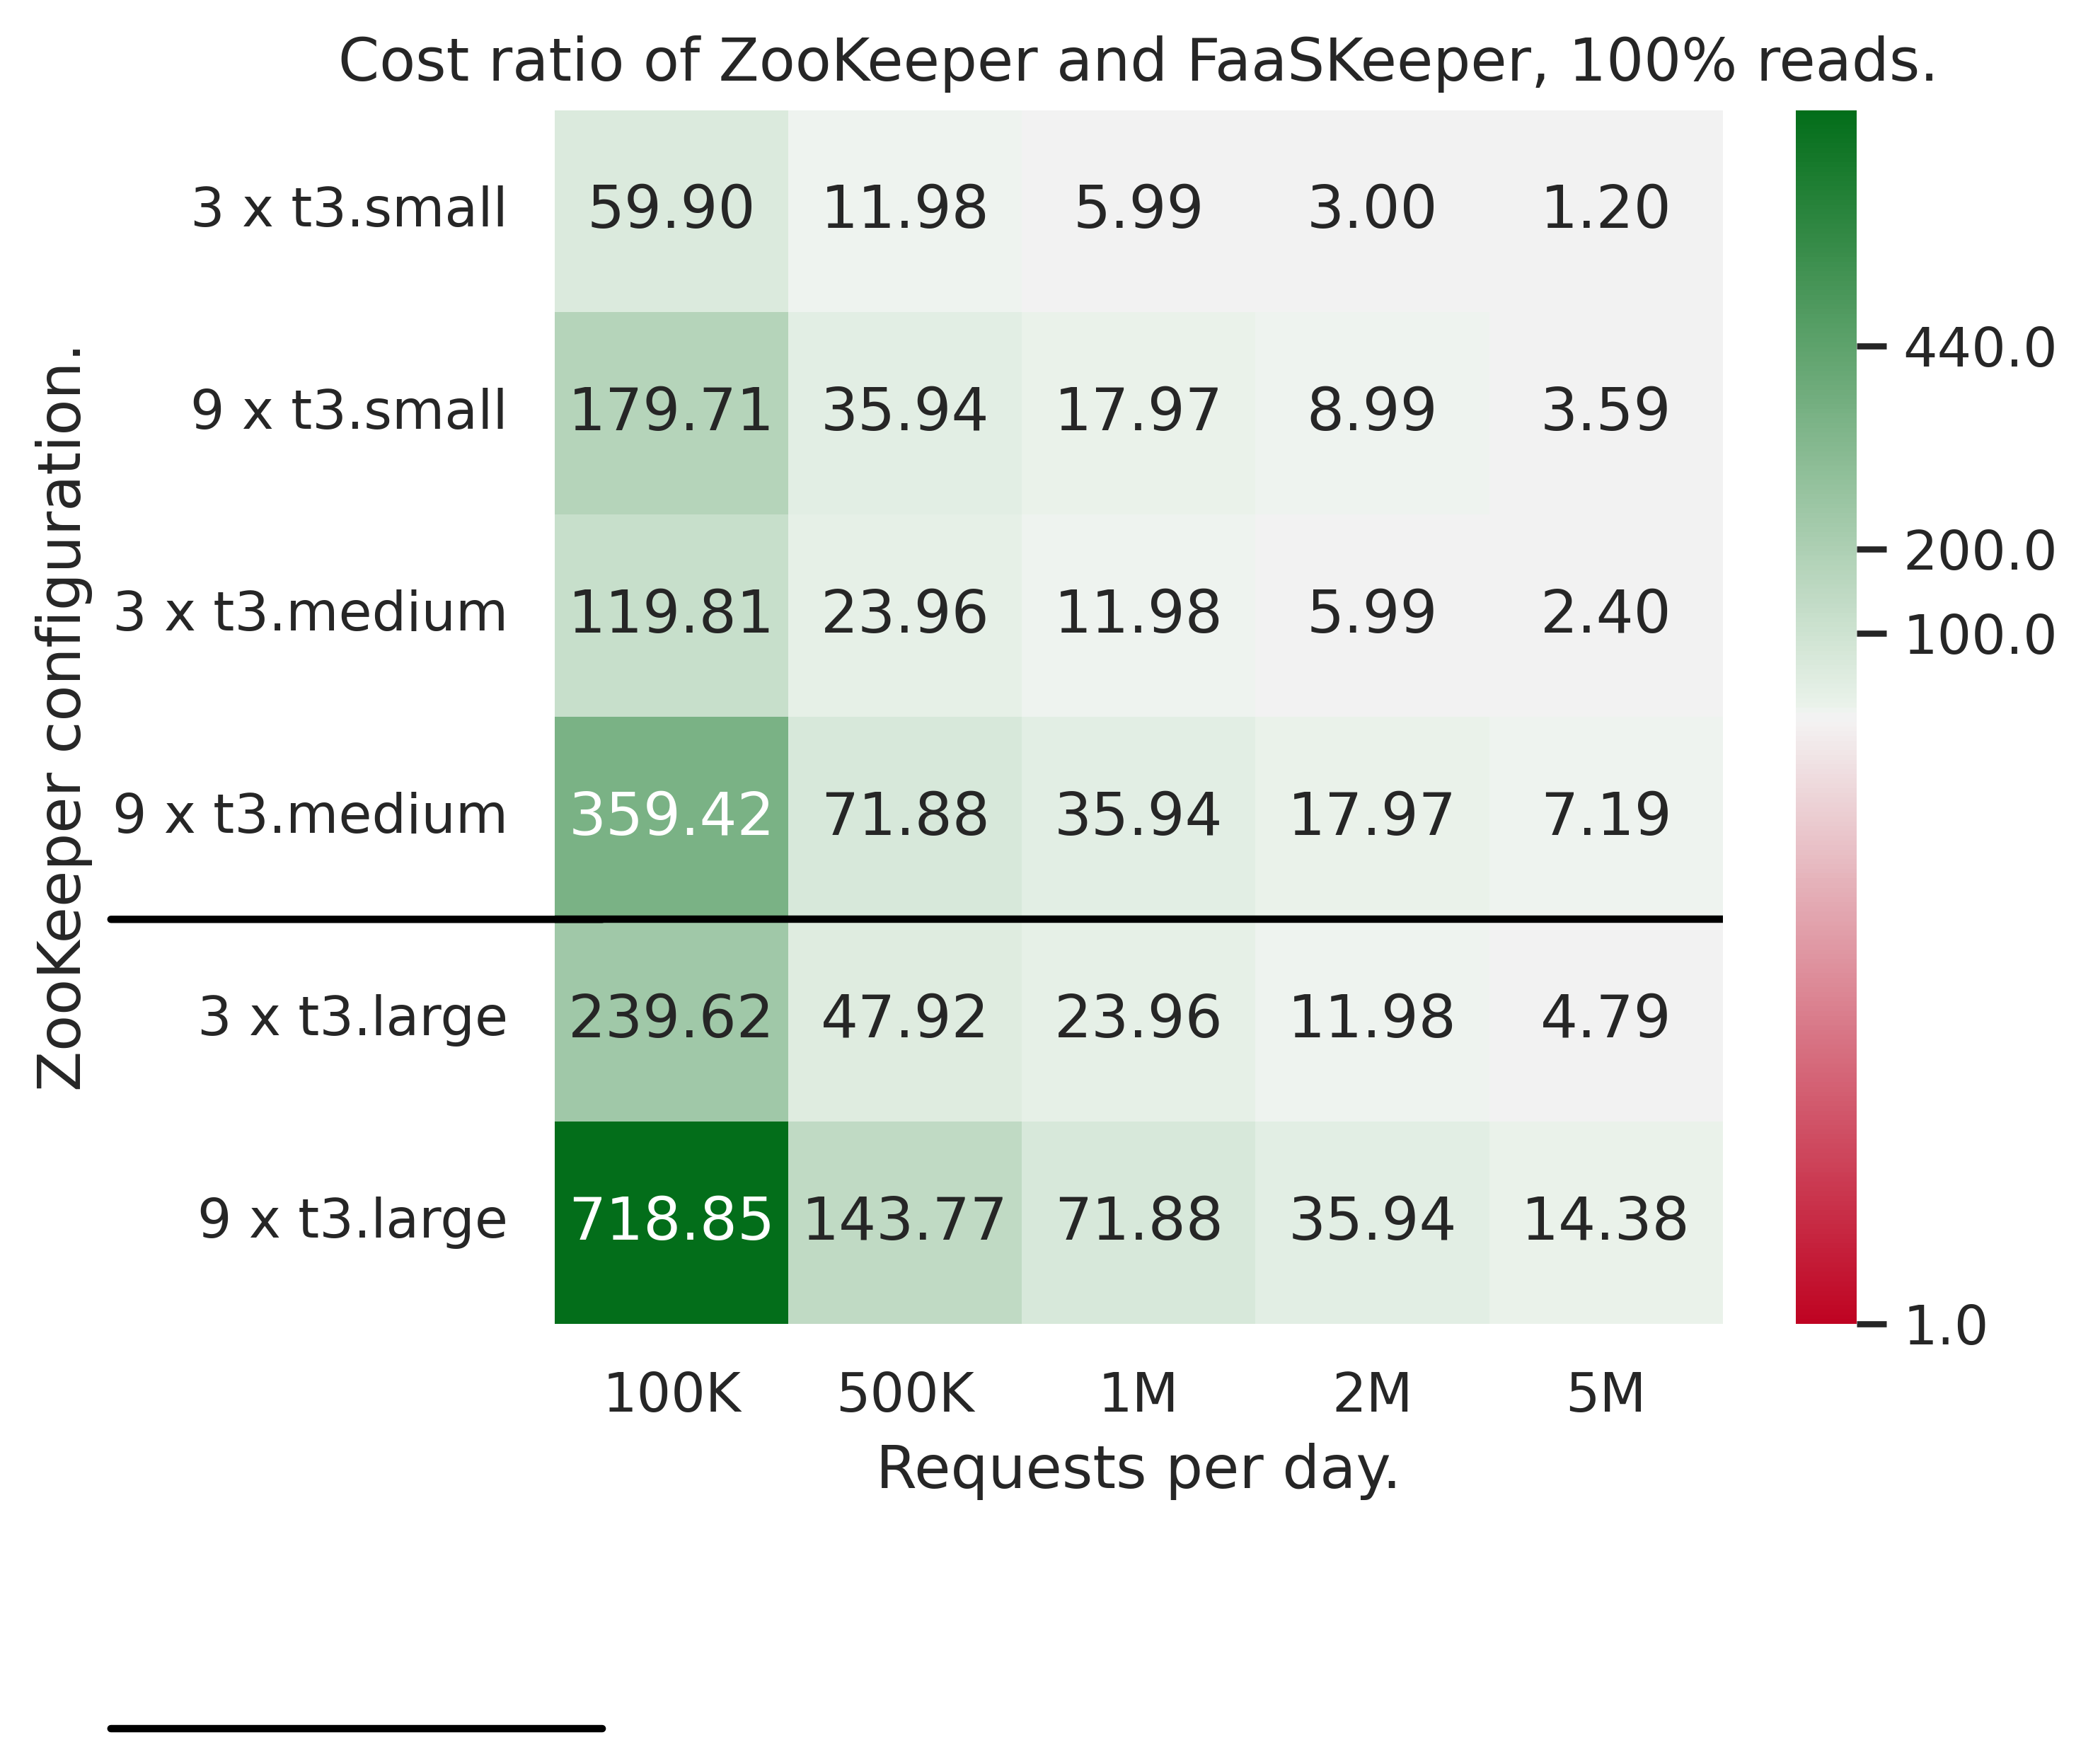

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.ticker as ticker

sns.set(rc={'figure.figsize':(6,4.5)})
#zk_vms = 3
t3_cost = {
    'small': 0.0208 * 24,
    'medium': 0.0416 * 24,
    'large': 0.0832 * 24
}        
#requests = [100, 250, 500, 750, 1000]
requests = [100, 500, 1000, 2000, 5000]
        
# 512 MB, 1 kB


results = []
labels = []

data = []
    
for size in ['small', 'medium', 'large']:
    for vms in [3, 9]:
        
        cost = 0.4 * 10**-6
        #cost = 0.25 * 10**-6
        ratio = 1.0
        
        y_cost = list(map(lambda x : ratio * x * cost + (1-ratio)*total_cost_classic(512,1)*x, [1000*x for x in requests]))
        zk_cost = [t3_cost[size] * vms] * len(y_cost)
        
        ratio = []
        for i in range(len(zk_cost)):
            ratio.append(zk_cost[i] / y_cost[i])
            data.append(ratio[-1])
        results.append(ratio)
        labels.append(f'{size}_{vms}')
        
        
for size in ['small', 'medium', 'large']:
    for vms in [3, 9]:
        
        #cost = 0.4 * 10**-6
        cost = 0.25 * 10**-6
        ratio = 1.0
        
        y_cost = list(map(lambda x : ratio * x * cost + (1-ratio)*total_cost(512,1)*x, [1000*x for x in requests]))
        zk_cost = [t3_cost[size] * vms] * len(y_cost)
        
        ratio = []
        for i in range(len(zk_cost)):
            ratio.append(zk_cost[i] / y_cost[i])
            data.append(ratio[-1])
        results.append(ratio)
        labels.append(f'{size}_{vms}')
        
data = np.array(data)
print(data)
requests_labels = ['100K', '500K', '1M', '2M', '5M']

labs = []

    
for size in ['small', 'medium', 'large']:
    for vms in [3, 9]:
        labs.append(f'{vms} x t3.{size}')

matrix_df = pd.DataFrame(results,columns=requests_labels,index=labs)#cols)

from matplotlib.colors import TwoSlopeNorm
rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=40, sep=3, as_cmap=True)
print(data.min(),1,data.max())
divnorm = TwoSlopeNorm(vmin=1, vcenter=data.min(), vmax=data.max())

fig = sns.heatmap(matrix_df,
            #cmap='Blues',
            #cmap="PiYG",
              cmap=rdgn,
              norm=divnorm,
            cbar=True,
            cbar_kws={'ticks': [0.75, 1, 100, 200, 440], 'format': '%.1f'},
            annot=True,
            fmt='.2f',
            vmax=70)
fig.set_xlabel('Requests per day.')
fig.set_ylabel('ZooKeeper configuration.')
fig.set_title('Cost ratio of ZooKeeper and FaaSKeeper, 100% reads.')
#fig.set_clip_on(False)

fig.annotate('',
    xy=(-1.9, 4), xycoords='data',
    xytext=(100, 0), textcoords='offset points', color='black',annotation_clip=False,
    arrowprops=dict(arrowstyle="-", lw=1.5,shrinkA=0, shrinkB=0,color='black'))
fig.annotate('',
    xy=(-1.9, 8), xycoords='data',
    xytext=(100, 0), textcoords='offset points', color='black',annotation_clip=False,
    arrowprops=dict(arrowstyle="-", lw=1.5,shrinkA=0, shrinkB=0,color='black'))
low, high = fig.get_xlim()
print(low, high)
fig.hlines([4, 8], low-150, high+150, colors='black')
#fig.axhline(4, low-150, high+150)
plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("new_cost_plot_100_hybrid.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

                                  request   time  billed_time  memory  \
0    a41cd615-0c35-5688-a6f7-8ba9a245aad7  42.76           43     512   
1    d0c809ba-e881-5071-ba96-540646f194fc  29.66           30     512   
2    1d29af01-850c-5681-8542-f2bd2b63dcca  26.05           27     512   
3    aa2bf827-5c95-5397-b167-a59bf2fa15b3  31.52           32     512   
4    d77cea66-1709-59a3-9a89-b7dab96693c2  26.10           27     512   
..                                    ...    ...          ...     ...   
746  30ed80b4-b749-5ea2-863e-dd080b2f1da2  27.03           28    2048   
747  276a6f4c-ae18-536a-b4ea-32f0127d6449  24.13           25    2048   
748  650d0b46-564b-501d-ad03-56faea2e0f26  23.93           24    2048   
749  3807f496-3ecc-594b-b648-a92a82a9ac82  25.22           26    2048   
750  53c48000-eee4-5886-b297-ddbc52ac06ab  46.33           47    2048   

     used_memory                                  read  write     function  \
0             75  a41cd615-0c35-5688-a6f7-8ba

{'writer': {512: [0.0175, 0.016, 0.0365, 0.0615, 0.112], 1024: [0.031, 0.036, 0.0475, 0.08, 0.126], 2048: [0.064, 0.064, 0.096, 0.134, 0.206]}, 'distributor': {512: [0.0305, 0.0305, 0.046, 0.0375, 0.0705], 1024: [0.066, 0.068, 0.087, 0.076, 0.1255], 2048: [0.126, 0.128, 0.174, 0.15, 0.266]}}
writer 512 0.9963644803002555
writer 512 0.01496649396738299
writer 512 [0.00038074]
writer 1024 0.9871717634364325
writer 1024 0.030832908798636094
writer 1024 [0.00037547]
writer 2048 0.9989504094929981
writer 2048 0.06237247868431657
writer 2048 [0.00056915]
distributor 512 0.8323095564870369
distributor 512 0.030133583324175074
distributor 512 [0.00014522]
distributor 1024 0.8340794980685053
distributor 1024 0.06564661347094553
distributor 1024 [0.00021279]
distributor 2048 0.8446768499321637
distributor 2048 0.12385090662481799
distributor 2048 [0.00050732]


1.0891340178201583
0.7141340178201583


In [23]:
import math
# PUT, COPY, POST, LIST requests (per 1,000 requests)
def write_s3(s):
    return  5*10**-6
def read_s3(s):
    return  0.4*10**-6
def write_dynamodb(s):
    return math.ceil(s) * 1.25 * 10**-6
def read_dynamodb(s):
    return math.ceil(s/4.0) * 0.25 * 10**-6
# FIFO Queues (per Million requests) 0.5
def sqs(s):
    return math.ceil(s/64.0) * 0.5 * 10**-6

lambda_const = 1.66667 * 10**-5

def writer_classic(m, s):
    return lambda_const*(coefficients_classic['writer'][m][0] * s + coefficients_classic['writer'][m][1]) + 0.2 * 10**-6
def distributor_classic(m, s):
    return lambda_const*(coefficients_classic['distributor'][m][0] * s + coefficients_classic['distributor'][m][1]) + 0.2 * 10**-6

def total_cost_classic(m, s):
    #return 2 * sqs(s) + 3 * write_dynamodb(1) + read_dynamodb(1) + write_s3(s) + writer(m, s) + distributor(m, s)
    return 2 * sqs(s) + 3 * write_dynamodb(1) + read_dynamodb(1) + write_s3(s) + writer_classic(m, s) + distributor_classic(m, s)


[ 37.44      7.488     3.744     1.872     0.7488   74.88     14.976
   7.488     3.744     1.4976  149.76     29.952    14.976     7.488
   2.9952  112.32     22.464    11.232     5.616     2.2464  224.64
  44.928    22.464    11.232     4.4928  449.28     89.856    44.928
  22.464     8.9856   59.904    11.9808    5.9904    2.9952    1.19808
 119.808    23.9616   11.9808    5.9904    2.39616 239.616    47.9232
  23.9616   11.9808    4.79232 179.712    35.9424   17.9712    8.9856
   3.59424 359.424    71.8848   35.9424   17.9712    7.18848 718.848
 143.7696   71.8848   35.9424   14.37696]
0.7487999999999999 1 718.8480000000001
0.0 5.0


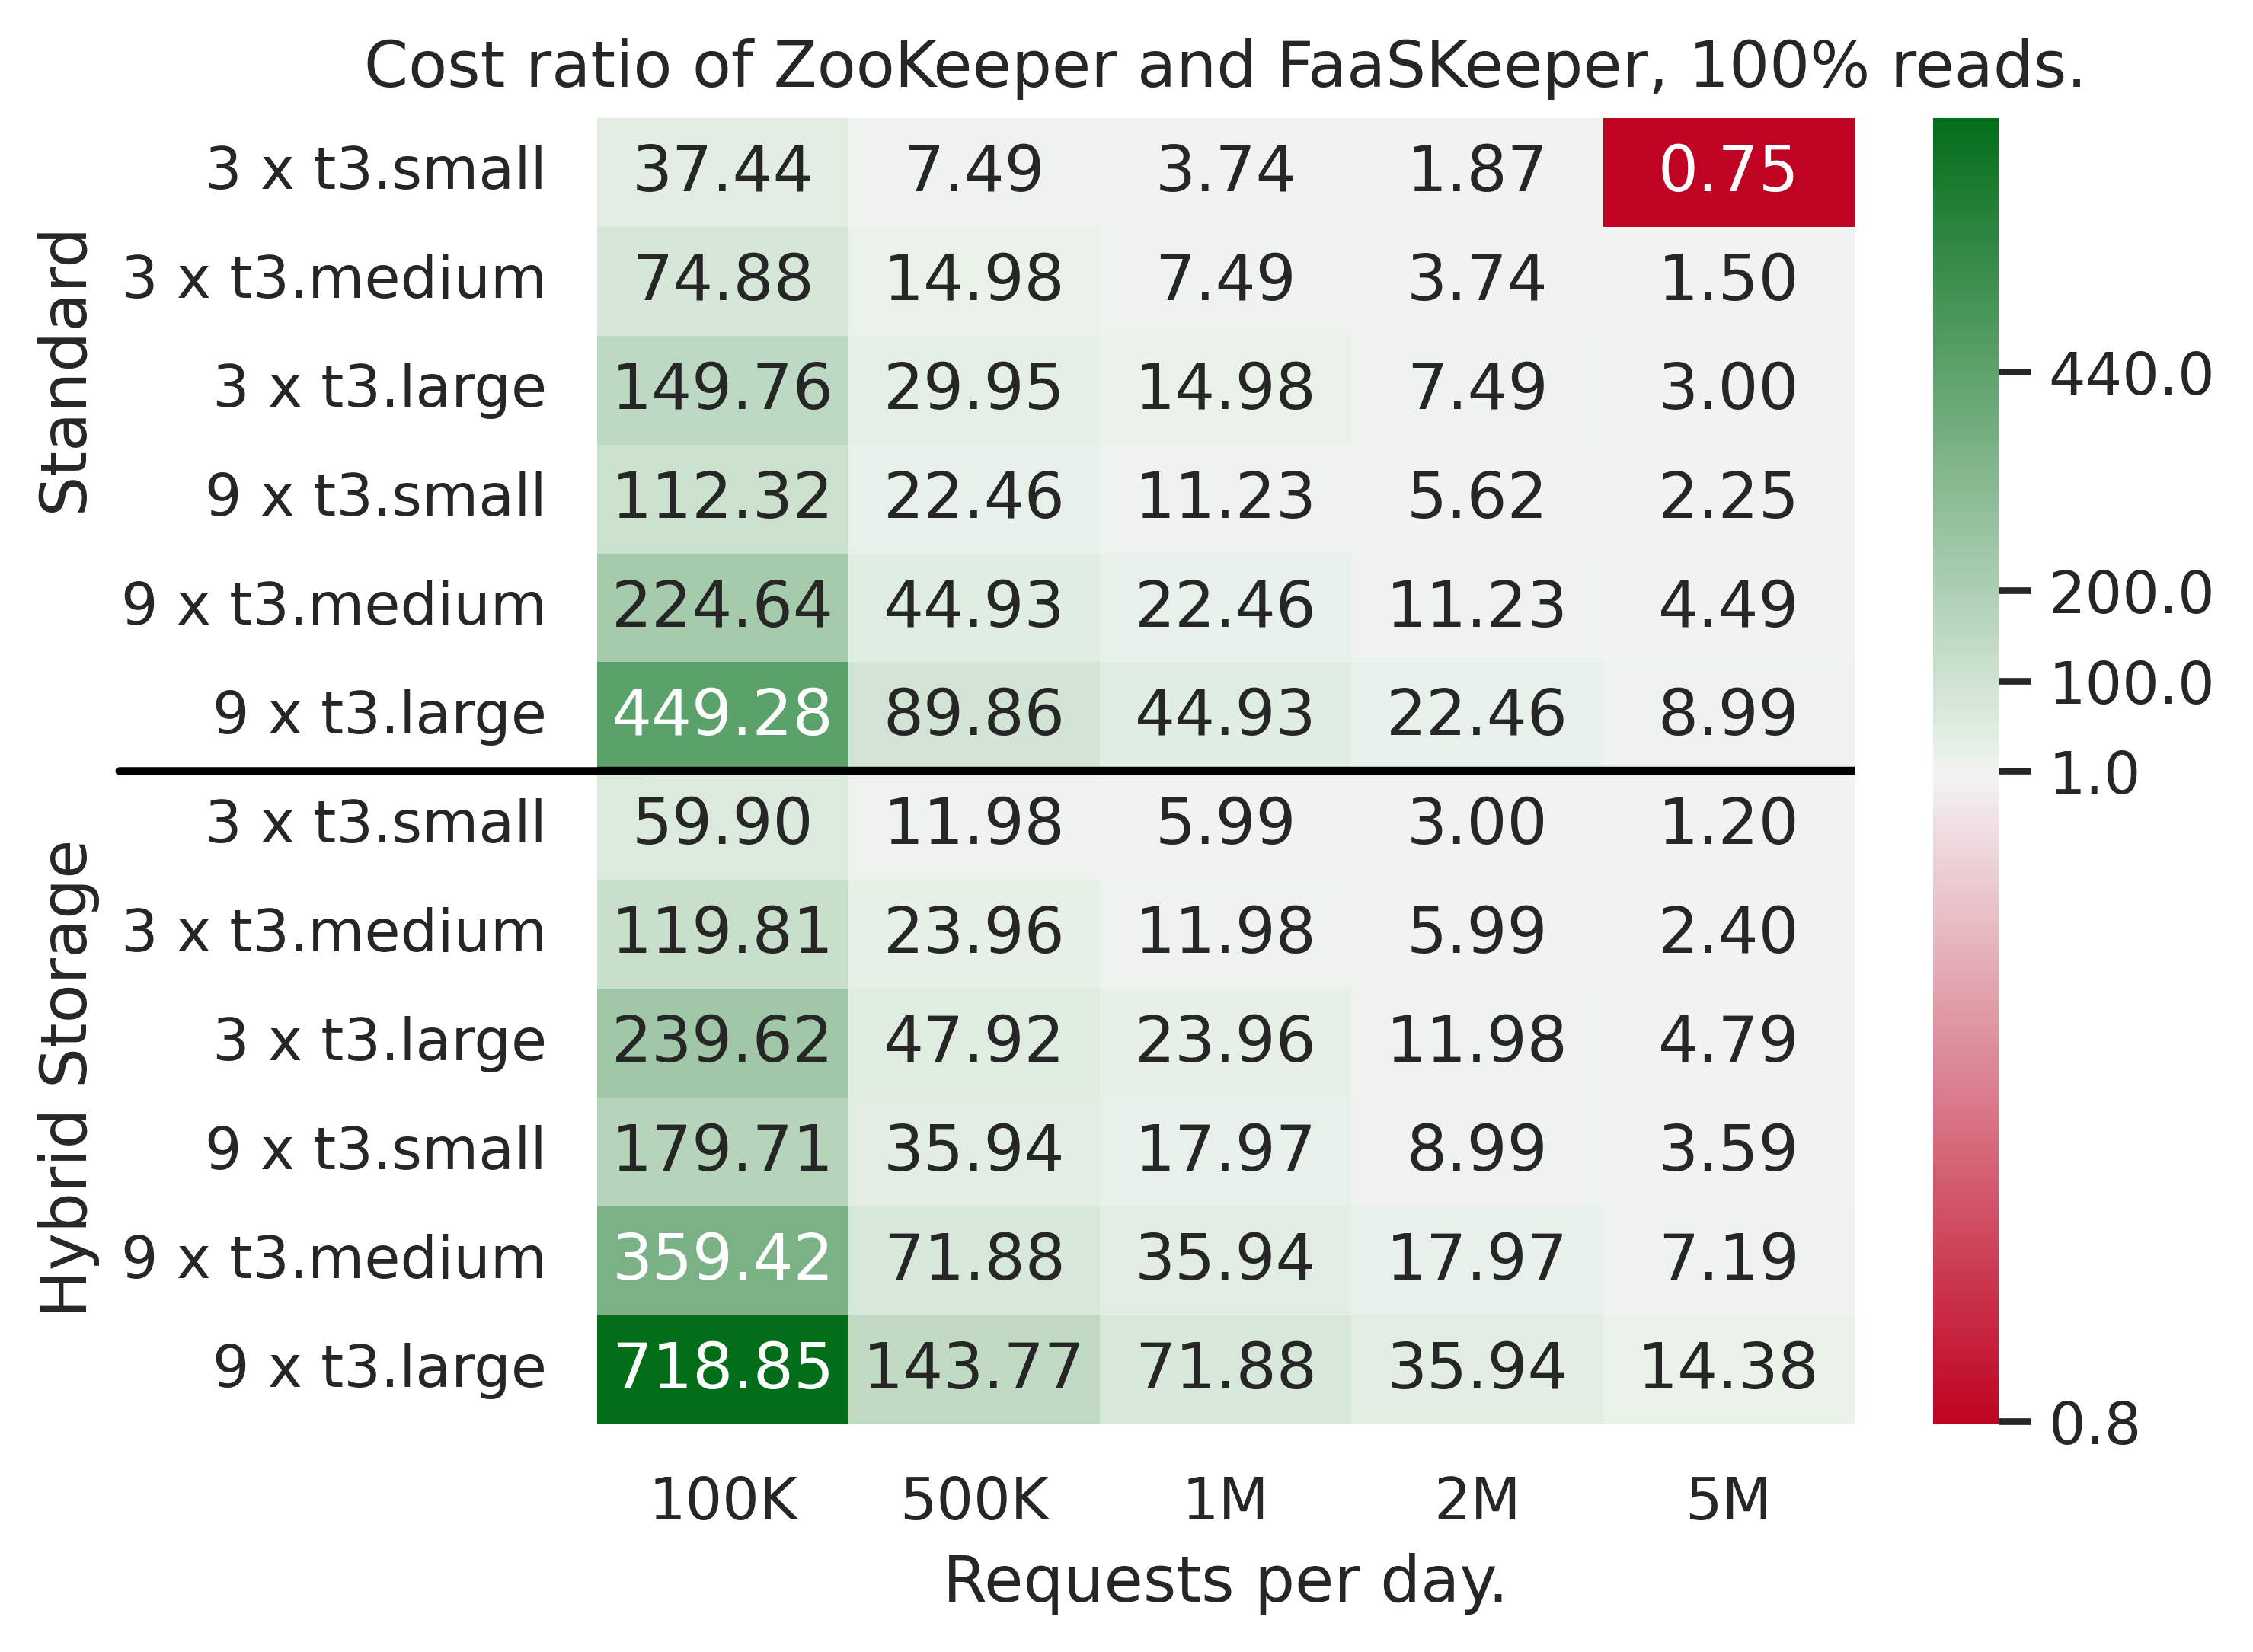

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.ticker as ticker
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set(rc={'figure.figsize':(6,4.5)})
#zk_vms = 3
t3_cost = {
    'small': 0.0208 * 24,
    'medium': 0.0416 * 24,
    'large': 0.0832 * 24
}        
#requests = [100, 250, 500, 750, 1000]
requests = [100, 500, 1000, 2000, 5000]
        
# 512 MB, 1 kB


results = []
labels = []

data = []
    
for vms in [3, 9]:
    for size in ['small', 'medium', 'large']:
        
        cost = 0.4 * 10**-6
        #cost = 0.25 * 10**-6
        ratio = 1.0
        
        y_cost = list(map(lambda x : ratio * x * cost + (1-ratio)*total_cost_classic(512,1)*x, [1000*x for x in requests]))
        zk_cost = [t3_cost[size] * vms] * len(y_cost)
        
        ratio = []
        for i in range(len(zk_cost)):
            ratio.append(zk_cost[i] / y_cost[i])
            data.append(ratio[-1])
        results.append(ratio)
        labels.append(f'{size}_{vms}')
        
for vms in [3, 9]:
    for size in ['small', 'medium', 'large']:
        
        #cost = 0.4 * 10**-6
        cost = 0.25 * 10**-6
        ratio = 1.0
        
        y_cost = list(map(lambda x : ratio * x * cost + (1-ratio)*total_cost(512,1)*x, [1000*x for x in requests]))
        zk_cost = [t3_cost[size] * vms] * len(y_cost)
        
        ratio = []
        for i in range(len(zk_cost)):
            ratio.append(zk_cost[i] / y_cost[i])
            data.append(ratio[-1])
        results.append(ratio)
        labels.append(f'{size}_{vms}')
        
data = np.array(data)
print(data)
requests_labels = ['100K', '500K', '1M', '2M', '5M']

labs = []

    
for vms in [3, 9]:
    for size in ['small', 'medium', 'large']:
        labs.append(f'{vms} x t3.{size}')
for vms in [3, 9]:
    for size in ['small', 'medium', 'large']:
        labs.append(f'{vms} x t3.{size}')

matrix_df = pd.DataFrame(results,columns=requests_labels,index=labs)#cols)

from matplotlib.colors import TwoSlopeNorm
rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=40, sep=3, as_cmap=True)
print(data.min(),1,data.max())
divnorm = TwoSlopeNorm(vmin=data.min(), vcenter=1,vmax=data.max())

fig = sns.heatmap(matrix_df,
            #cmap='Blues',
            #cmap="PiYG",
              cmap=rdgn,
              norm=divnorm,
            cbar=True,
            cbar_kws={'ticks': [0.75, 1, 100, 200, 440], 'format': '%.1f'},
            annot=True,
            fmt='.2f',
            vmax=70)
fig.set_xlabel('Requests per day.')
#fig.set_ylabel('ZooKeeper configuration.')
fig.set_ylabel('Hybrid Storage                Standard')
fig.set_title('Cost ratio of ZooKeeper and FaaSKeeper, 100% reads.')
#fig.set_clip_on(False)

#fig.annotate('',
#    xy=(-1.9, 4), xycoords='data',
#    xytext=(100, 0), textcoords='offset points', color='black',annotation_clip=False,
#    arrowprops=dict(arrowstyle="-", lw=1.5,shrinkA=0, shrinkB=0,color='black'))
fig.annotate('',
    xy=(-1.9, 6), xycoords='data',
    xytext=(100, 0), textcoords='offset points', color='black',annotation_clip=False,
    arrowprops=dict(arrowstyle="-", lw=1.5,shrinkA=0, shrinkB=0,color='black'))


low, high = fig.get_xlim()
print(low, high)
#fig.hlines([4, 8], low-150, high+150, colors='black')
fig.hlines([6], low-150, high+150, colors='black')
#fig.axhline(4, low-150, high+150)
plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("new_cost_plot_100_hybrid.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

[ 10.14604219   2.02920844   1.01460422   0.50730211   0.20292084
  20.29208437   4.05841687   2.02920844   1.01460422   0.40584169
  40.58416875   8.11683375   4.05841687   2.02920844   0.81168337
  30.43812656   6.08762531   3.04381266   1.52190633   0.60876253
  60.87625312  12.17525062   6.08762531   3.04381266   1.21752506
 121.75250624  24.35050125  12.17525062   6.08762531   2.43505012
  15.8896534    3.17793068   1.58896534   0.79448267   0.31779307
  31.7793068    6.35586136   3.17793068   1.58896534   0.63558614
  63.55861361  12.71172272   6.35586136   3.17793068   1.27117227
  47.66896021   9.53379204   4.76689602   2.38344801   0.9533792
  95.33792041  19.06758408   9.53379204   4.76689602   1.90675841
 190.67584083  38.13516817  19.06758408   9.53379204   3.81351682]
0.20292084373293098 1 190.67584082656418
0.0 5.0


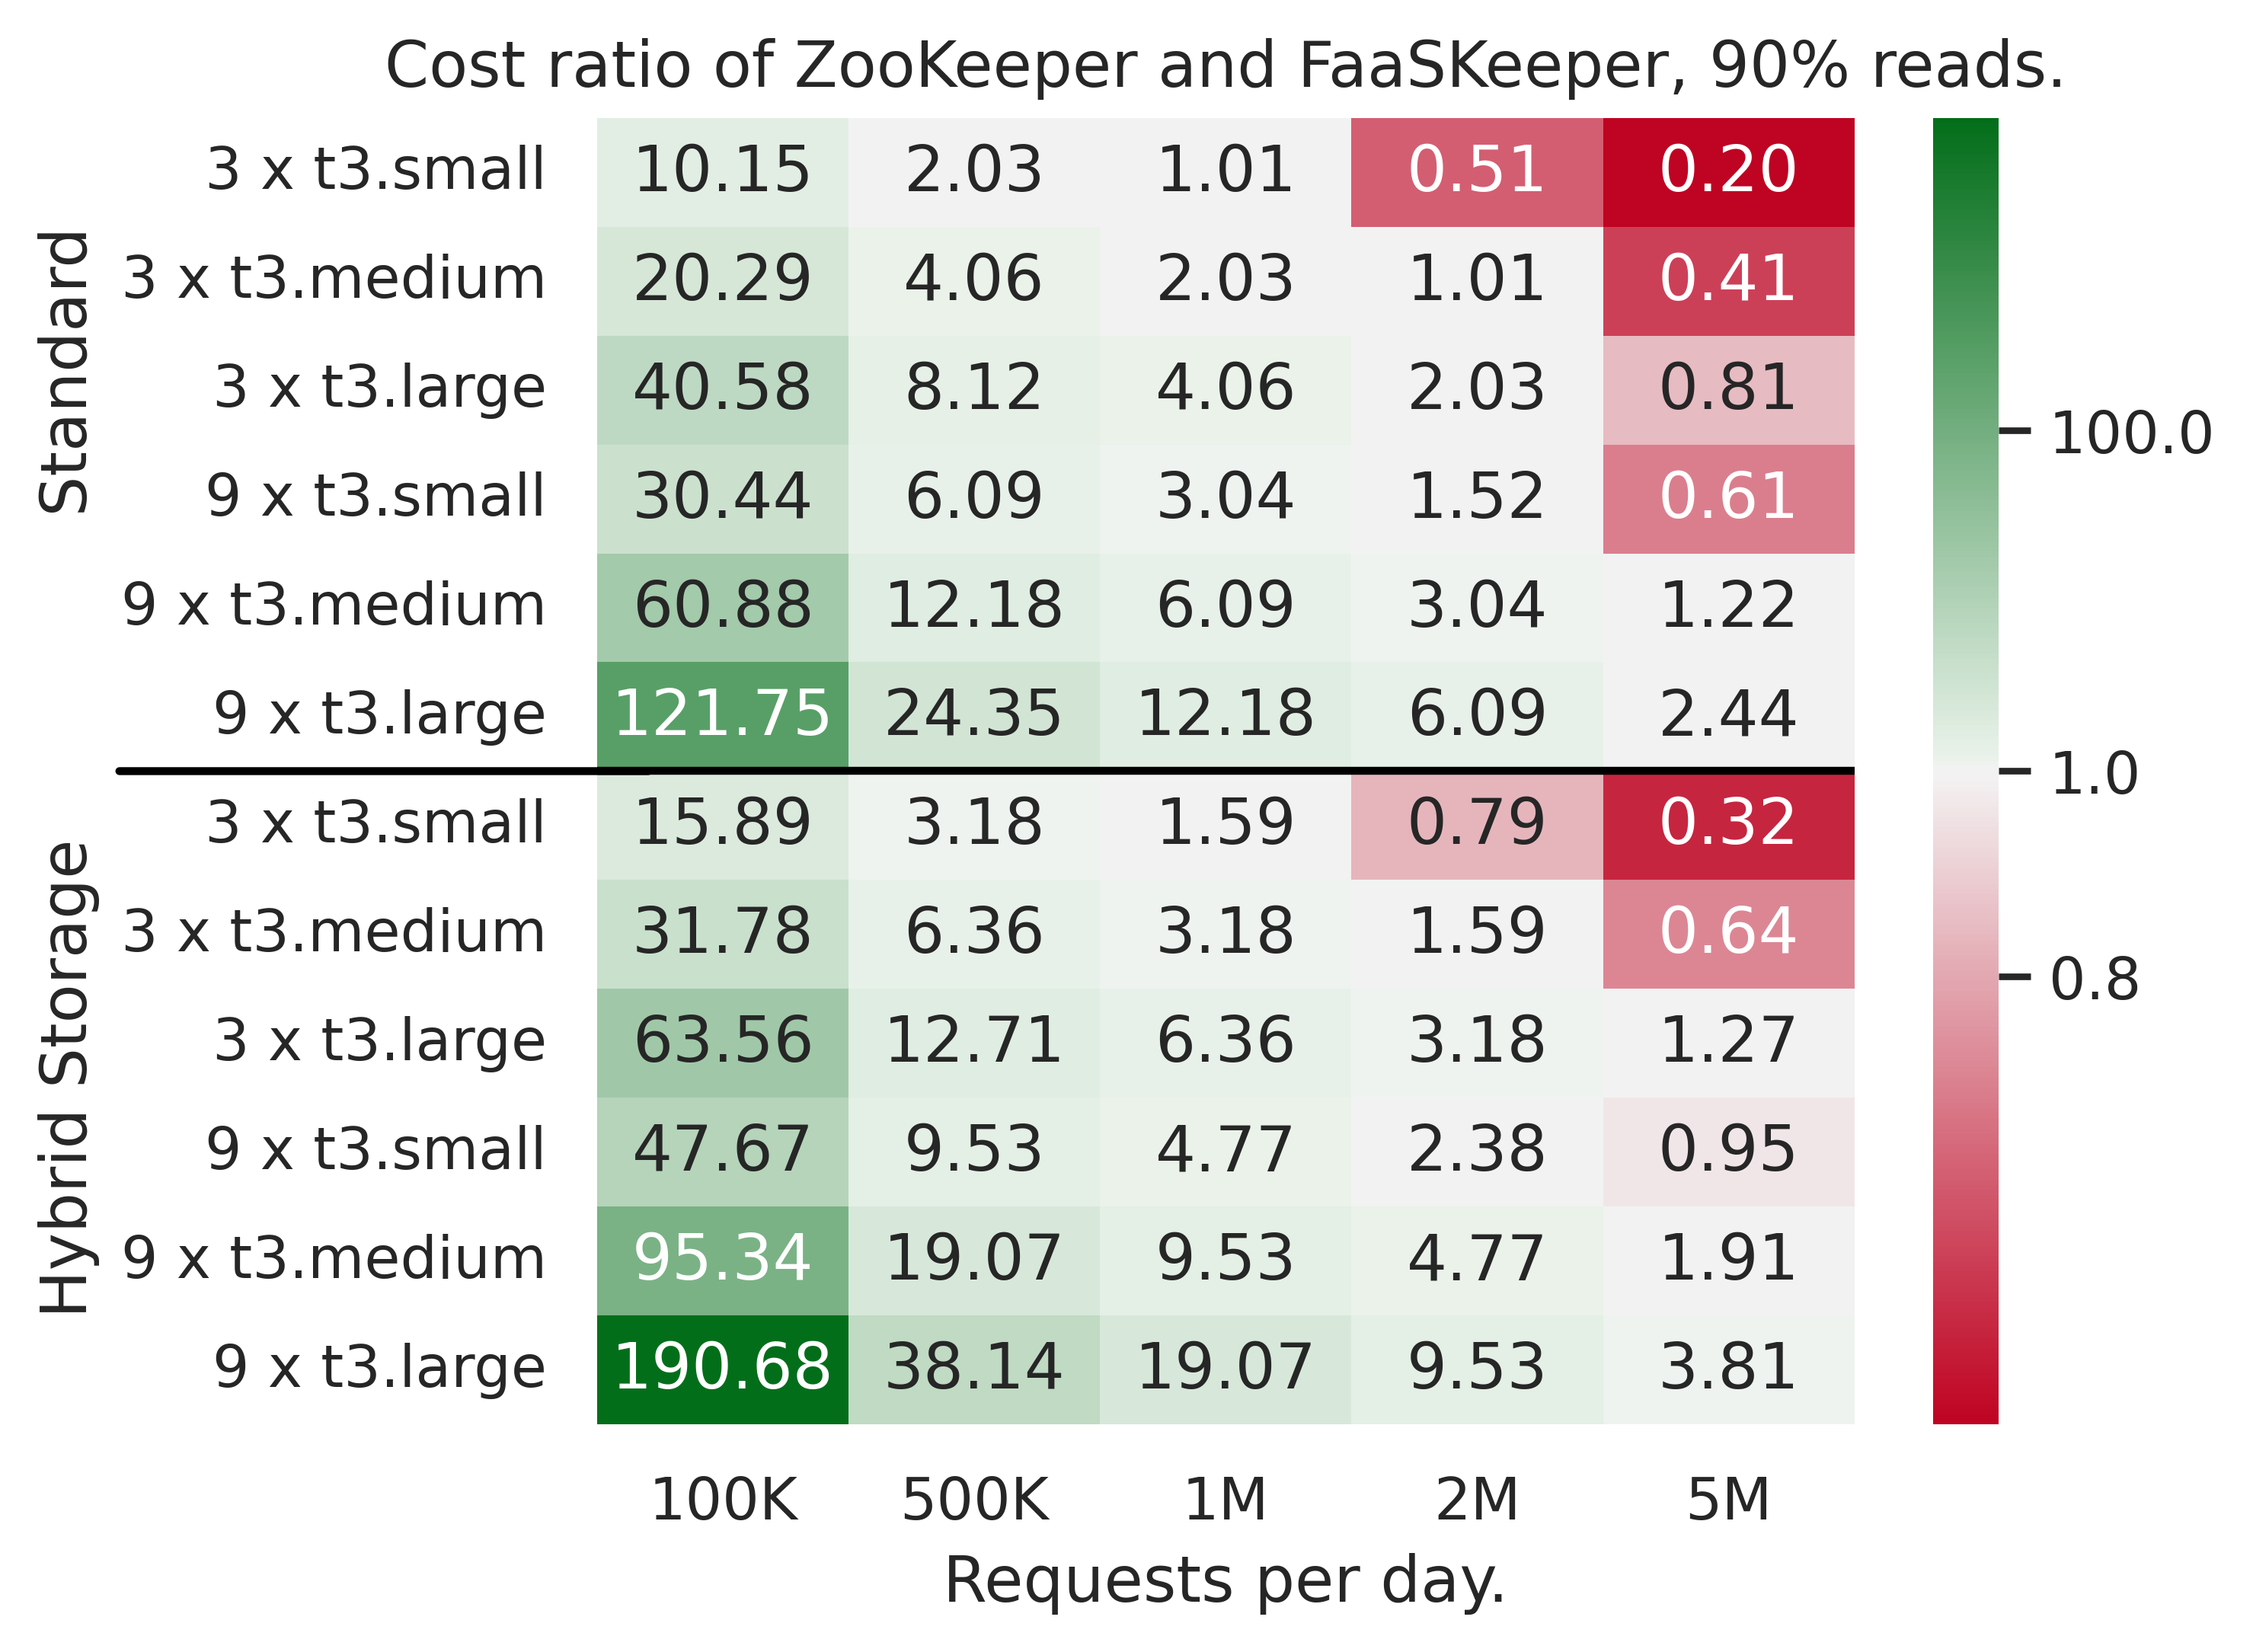

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.ticker as ticker
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


sns.set(rc={'figure.figsize':(6,4.5)})
#zk_vms = 3
t3_cost = {
    'small': 0.0208 * 24,
    'medium': 0.0416 * 24,
    'large': 0.0832 * 24
}        
#requests = [100, 250, 500, 750, 1000]
requests = [100, 500, 1000, 2000, 5000]
        
# 512 MB, 1 kB


results = []
labels = []

data = []
    
for vms in [3, 9]:
    for size in ['small', 'medium', 'large']:
        
        cost = 0.4 * 10**-6
        #cost = 0.25 * 10**-6
        ratio = 0.9
        
        y_cost = list(map(lambda x : ratio * x * cost + (1-ratio)*total_cost_classic(512,1)*x, [1000*x for x in requests]))
        zk_cost = [t3_cost[size] * vms] * len(y_cost)
        
        ratio = []
        for i in range(len(zk_cost)):
            ratio.append(zk_cost[i] / y_cost[i])
            data.append(ratio[-1])
        results.append(ratio)
        labels.append(f'{size}_{vms}')
        
        
for vms in [3, 9]:
    for size in ['small', 'medium', 'large']:
        
        #cost = 0.4 * 10**-6
        cost = 0.25 * 10**-6
        ratio = 0.9
        
        y_cost = list(map(lambda x : ratio * x * cost + (1-ratio)*total_cost(512,1)*x, [1000*x for x in requests]))
        zk_cost = [t3_cost[size] * vms] * len(y_cost)
        
        ratio = []
        for i in range(len(zk_cost)):
            ratio.append(zk_cost[i] / y_cost[i])
            data.append(ratio[-1])
        results.append(ratio)
        labels.append(f'{size}_{vms}')
        
data = np.array(data)
print(data)
requests_labels = ['100K', '500K', '1M', '2M', '5M']

labs = []

    
for vms in [3, 9]:
    for size in ['small', 'medium', 'large']:
        labs.append(f'{vms} x t3.{size}')
for vms in [3, 9]:
    for size in ['small', 'medium', 'large']:
        labs.append(f'{vms} x t3.{size}')

matrix_df = pd.DataFrame(results,columns=requests_labels,index=labs)#cols)

from matplotlib.colors import TwoSlopeNorm
rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=40, sep=3, as_cmap=True)
print(data.min(),1,data.max())
divnorm = TwoSlopeNorm(vmin=data.min(), vcenter=1,vmax=data.max())

fig = sns.heatmap(matrix_df,
            #cmap='Blues',
            #cmap="PiYG",
              cmap=rdgn,
              norm=divnorm,
            cbar=True,
            cbar_kws={'ticks': [0.75, 1, 100, 200, 440], 'format': '%.1f'},
            annot=True,
            fmt='.2f',
            vmax=70)
fig.set_xlabel('Requests per day.')
#fig.set_ylabel('ZooKeeper configuration.')
fig.set_ylabel('Hybrid Storage                Standard')
fig.set_title('Cost ratio of ZooKeeper and FaaSKeeper, 90% reads.')
#fig.set_clip_on(False)

#fig.annotate('',
#    xy=(-1.9, 4), xycoords='data',
#    xytext=(100, 0), textcoords='offset points', color='black',annotation_clip=False,
#    arrowprops=dict(arrowstyle="-", lw=1.5,shrinkA=0, shrinkB=0,color='black'))
fig.annotate('',
    xy=(-1.9, 6), xycoords='data',
    xytext=(100, 0), textcoords='offset points', color='black',annotation_clip=False,
    arrowprops=dict(arrowstyle="-", lw=1.5,shrinkA=0, shrinkB=0,color='black'))


low, high = fig.get_xlim()
print(low, high)
#fig.hlines([4, 8], low-150, high+150, colors='black')
fig.hlines([6], low-150, high+150, colors='black')
#fig.axhline(4, low-150, high+150)
plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("new_cost_plot_90_hybrid.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

[  5.86813834   1.17362767   0.58681383   0.29340692   0.11736277
  11.73627667   2.34725533   1.17362767   0.58681383   0.23472553
  23.47255334   4.69451067   2.34725533   1.17362767   0.46945107
  17.60441501   3.520883     1.7604415    0.88022075   0.3520883
  35.20883001   7.041766     3.520883     1.7604415    0.7041766
  70.41766003  14.08353201   7.041766     3.520883     1.4083532
   9.15963185   1.83192637   0.91596319   0.45798159   0.18319264
  18.3192637    3.66385274   1.83192637   0.91596319   0.36638527
  36.6385274    7.32770548   3.66385274   1.83192637   0.73277055
  27.47889555   5.49577911   2.74788956   1.37394478   0.54957791
  54.95779111  10.99155822   5.49577911   2.74788956   1.09915582
 109.91558221  21.98311644  10.99155822   5.49577911   2.19831164]
0.11736276671459347 1 109.91558221267755
0.0 5.0


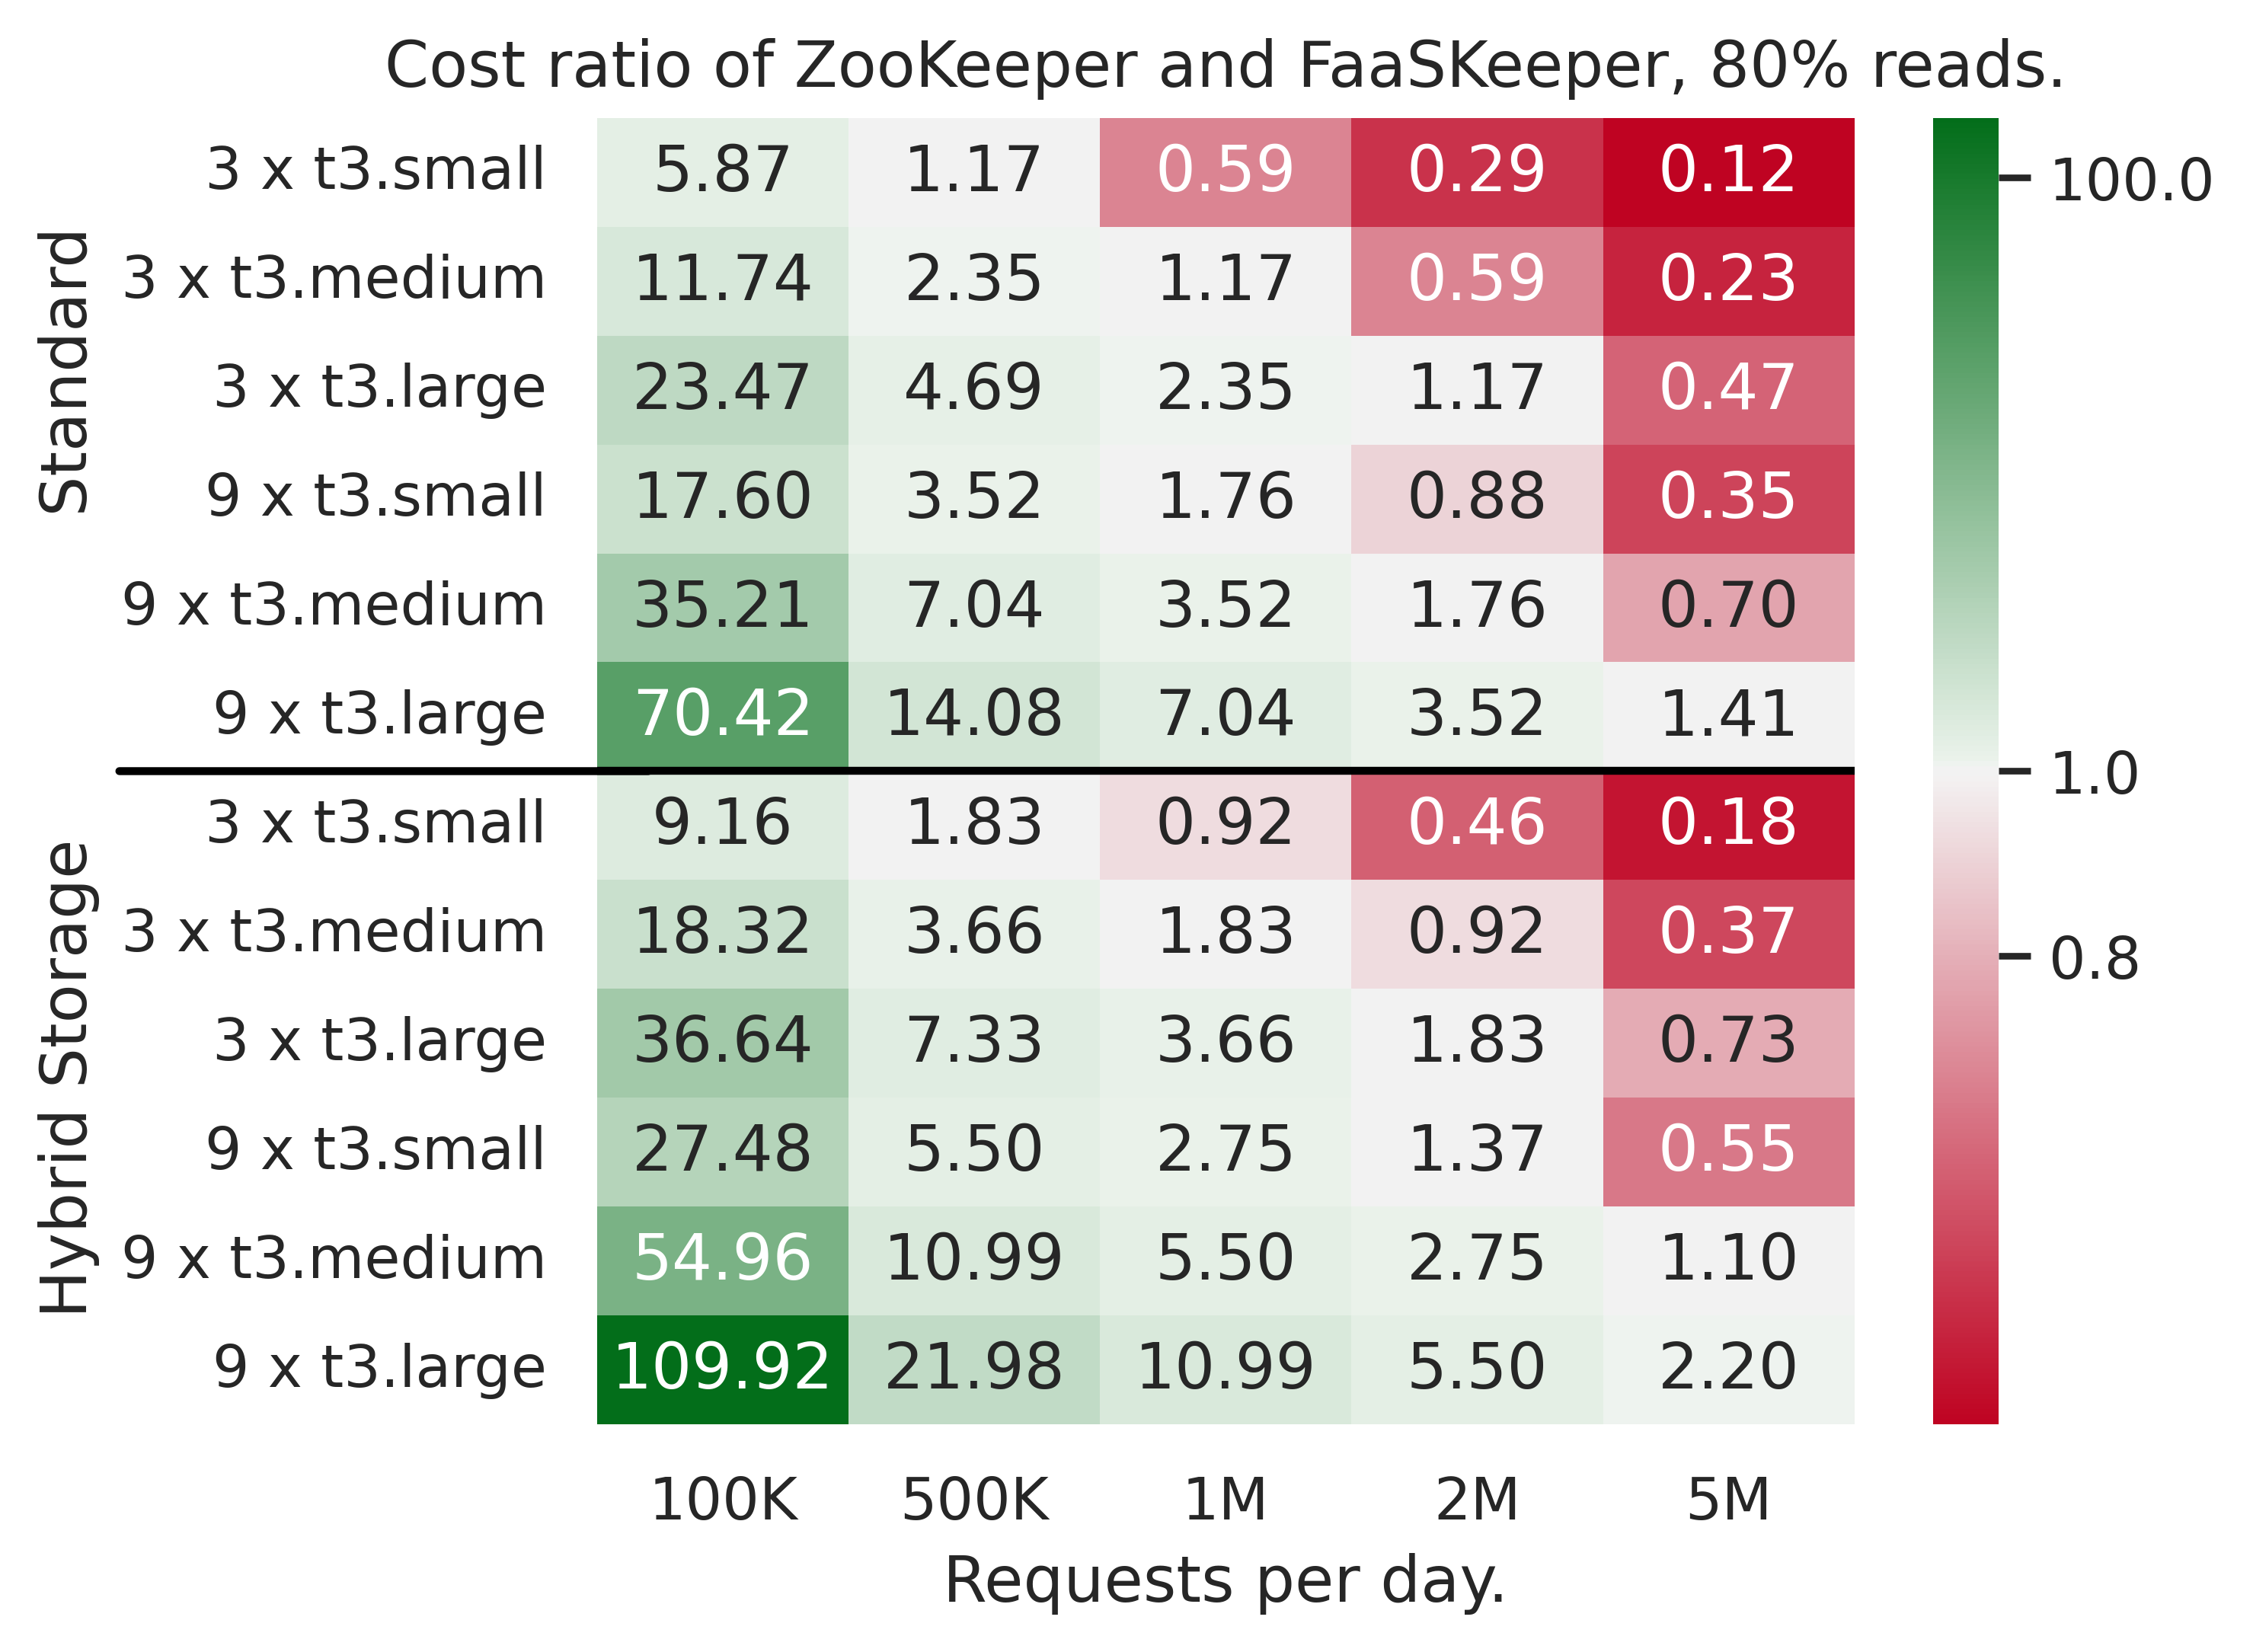

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.ticker as ticker
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


sns.set(rc={'figure.figsize':(6,4.5)})
#zk_vms = 3
t3_cost = {
    'small': 0.0208 * 24,
    'medium': 0.0416 * 24,
    'large': 0.0832 * 24
}        
#requests = [100, 250, 500, 750, 1000]
requests = [100, 500, 1000, 2000, 5000]
        
# 512 MB, 1 kB


results = []
labels = []

data = []
    
#for size in ['small', 'medium', 'large']:
#    for vms in [3, 9]:
for vms in [3, 9]:
    for size in ['small', 'medium', 'large']:
        
        cost = 0.4 * 10**-6
        #cost = 0.25 * 10**-6
        ratio = 0.80
        
        y_cost = list(map(lambda x : ratio * x * cost + (1-ratio)*total_cost_classic(512,1)*x, [1000*x for x in requests]))
        zk_cost = [t3_cost[size] * vms] * len(y_cost)
        
        ratio = []
        for i in range(len(zk_cost)):
            ratio.append(zk_cost[i] / y_cost[i])
            data.append(ratio[-1])
        results.append(ratio)
        labels.append(f'{size}_{vms}')
        
        
#for size in ['small', 'medium', 'large']:
#    for vms in [3, 9]:
for vms in [3, 9]:
    for size in ['small', 'medium', 'large']:
        
        #cost = 0.4 * 10**-6
        cost = 0.25 * 10**-6
        ratio = 0.80
        
        y_cost = list(map(lambda x : ratio * x * cost + (1-ratio)*total_cost(512,1)*x, [1000*x for x in requests]))
        zk_cost = [t3_cost[size] * vms] * len(y_cost)
        
        ratio = []
        for i in range(len(zk_cost)):
            ratio.append(zk_cost[i] / y_cost[i])
            data.append(ratio[-1])
        results.append(ratio)
        labels.append(f'{size}_{vms}')
        
data = np.array(data)
print(data)
requests_labels = ['100K', '500K', '1M', '2M', '5M']

labs = []

    
#for size in ['small', 'medium', 'large']:
#    for vms in [3, 9]:
for vms in [3, 9]:
    for size in ['small', 'medium', 'large']:
        labs.append(f'{vms} x t3.{size}')
#for size in ['small', 'medium', 'large']:
#    for vms in [3, 9]:
for vms in [3, 9]:
    for size in ['small', 'medium', 'large']:
        labs.append(f'{vms} x t3.{size}')

matrix_df = pd.DataFrame(results,columns=requests_labels,index=labs)#cols)

from matplotlib.colors import TwoSlopeNorm
rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=40, sep=3, as_cmap=True)
print(data.min(),1,data.max())
divnorm = TwoSlopeNorm(vmin=data.min(), vcenter=1,vmax=data.max())

fig = sns.heatmap(matrix_df,
            #cmap='Blues',
            #cmap="PiYG",
              cmap=rdgn,
              norm=divnorm,
            cbar=True,
            cbar_kws={'ticks': [0.75, 1, 100, 200, 440], 'format': '%.1f'},
            annot=True,
            fmt='.2f',
            vmax=70)
fig.set_xlabel('Requests per day.')
#fig.set_ylabel('ZooKeeper configuration.')
fig.set_ylabel('Hybrid Storage                Standard')
fig.set_title('Cost ratio of ZooKeeper and FaaSKeeper, 80% reads.')
#fig.set_clip_on(False)

#fig.annotate('',
#    xy=(-1.9, 4), xycoords='data',
#    xytext=(100, 0), textcoords='offset points', color='black',annotation_clip=False,
#    arrowprops=dict(arrowstyle="-", lw=1.5,shrinkA=0, shrinkB=0,color='black'))
fig.annotate('',
    xy=(-1.9, 6), xycoords='data',
    xytext=(100, 0), textcoords='offset points', color='black',annotation_clip=False,
    arrowprops=dict(arrowstyle="-", lw=1.5,shrinkA=0, shrinkB=0,color='black'))


low, high = fig.get_xlim()
print(low, high)
#fig.hlines([4, 8], low-150, high+150, colors='black')
fig.hlines([6], low-150, high+150, colors='black')
#fig.axhline(4, low-150, high+150)
plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("new_cost_plot_80_hybrid.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

In [56]:

t3_small = 0.0208 * 24,
t3_medium = 0.0416 * 24
t3_large = 0.0832 * 24

zk_vms = 3
t3_small = zk_vms * 0.0208 * 24
t3_medium = zk_vms * 0.0416 * 24
t3_large = zk_vms * 0.0832 * 24

ratio = 1.0
cost = ratio * 0.4 * 10**-6 + (1-ratio)*total_cost_classic(512, 1)

print(t3_small, cost, t3_small/cost)
ratio = 0.9
cost = ratio * 0.4 * 10**-6 + (1-ratio)*total_cost_classic(512, 1)

print(t3_small, cost, t3_small/cost)
ratio = 0.75
cost = ratio * 0.4 * 10**-6 + (1-ratio)*total_cost_classic(512, 1)
print(t3_medium, cost, t3_medium/cost)

1.4975999999999998 4e-07 3743999.9999999995
1.4975999999999998 1.4760435373358115e-06 1014604.2187231799
2.9951999999999996 3.090108843339529e-06 969286.2458407904


In [57]:

t3_small = 0.0208 * 24,
t3_medium = 0.0416 * 24
t3_large = 0.0832 * 24

zk_vms = 3
t3_small = zk_vms * 0.0208 * 24
t3_medium = zk_vms * 0.0416 * 24
t3_large = zk_vms * 0.0832 * 24

ratio = 1.0
cost = ratio * 0.25 * 10**-6 + (1-ratio)*total_cost(512, 1)

print(t3_small, cost, t3_small/cost)
ratio = 0.9
cost = ratio * 0.25 * 10**-6 + (1-ratio)*total_cost(512, 1)

print(t3_small, cost, t3_small/cost)
ratio = 0.75
cost = ratio * 0.25 * 10**-6 + (1-ratio)*total_cost(512, 1)
print(t3_medium, cost, t3_medium/cost)

1.4975999999999998 2.5e-07 5990400.0
1.4975999999999998 9.391340178201582e-07 1594660.5826036497
2.9951999999999996 1.9728350445503957e-06 1518221.205707849


### GCP

In [ ]:
import math
# PUT, COPY, POST, LIST requests (per 1,000 requests)


def write_cs(s):
    return  5*10**-6
def read_cs(s):
    return  0.4*10**-6

def write_datastore(s):
    return 0.18 * 10**-5
def read_datastore(s):
    return 0.05 * 10**-5

# FIFO Queues (per Million requests) 0.5
def google_queue(s):
    return 2 * 40 / 1024 /  1024 / 1024 * s 

lambda_const = 1.66667 * 10**-5

# fixed for the size = 1 kB, 512 MB
def writer_gcp_classic(m, s):
    return 0 #lambda_const*(coefficients['writer'][m][0] * s + coefficients['writer'][m][1]) + 0.2 * 10**-6
def distributor_gcp_classic(m, s):
    return 0 #lambda_const*(coefficients['distributor'][m][0] * s + coefficients['distributor'][m][1]) + 0.2 * 10**-6

#def total_cost(m, s):
    #return 2 * sqs(s) + 3 * write_dynamodb(1) + read_dynamodb(1) + write_s3(s) + writer(m, s) + distributor(m, s)
#    return 2 * sqs(s) + 3 * write_dynamodb(1) + read_dynamodb(1) + write_dynamodb(s) + writer_classic(m, s) + distributor(m, s)

def total_cost_gcp(m, s):
    #return 2 * sqs(s) + 3 * write_dynamodb(1) + read_dynamodb(1) + write_s3(s) + writer(m, s) + distributor(m, s)
    return 2 * google_queue(s) + 3 * write_datastore(1) + read_datastore(1) + write_cs(s) + writer_gcp_classic(m, s) + distributor_gcp_classic(m, s)
